# Experiment design walkdown 

Can we modify the simulation to create an experiment that we can actually test? How many samples will we need in order to do so?

Todo:

- [ ] Walk down to continuous time (instead of discrete time)

In [1]:
%pylab inline
import networkx as nx
import numpy as np
import itertools
import pandas as pd
import copy
from sklearn.decomposition import PCA
from scipy import stats

import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)

Populating the interactive namespace from numpy and matplotlib


# Shared Functions
These do not change

In [2]:
def drawfigs(runs,
             measures=['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)'],
             n_samples=30, ax1=None, ax2=None):
    
    if ax1 is None:
        ax1 = plt.subplot(2,1,1)
        
    ax1.hist(runs[measures[0]] - runs[measures[1]], bins=20);
    ax1.vlines((runs[measures[0]] - runs[measures[1]]).mean(),0,10, 'r')
    ax1.set_xlabel('Difference')
    ax1.set_ylabel('Number of runs')
    ax1.set_title("%s -\n%s"%(measures[0], measures[1]))
    
    if ax2 is None:
        ax2 = plt.subplot(2,1,2)
        
    n_runs = len(runs)
    res = {}
    for n_reps in range(2,n_samples):  # sample sizes to try
        p_vals = []
        for i in range(100): # number of times to try each sample size
            # 'conduct' experiment
            sample = runs.iloc[np.random.randint(n_runs, size=n_reps)]
            p_vals.append(stats.ttest_rel(sample[measures[0]], sample[measures[1]])[1])
        res[n_reps] = p_vals

    resdf = pd.DataFrame(res)

    resdf.unstack().droplevel(1).plot(linewidth=0, marker='+', alpha=.4, ax=ax2)
    resdf.mean().plot(linewidth=1, color='b', ax=ax2)
    ax2.set_ylabel('P Value')
    ax2.set_xticks(range(2,n_samples))
    ax2.set_xlabel('Number of sample pairs')

    ax3 = ax2.twinx()
    ax3.plot(resdf.columns, (resdf < .05).mean()*100, 'r')
    ax3.set_ylabel('% Experiments with p<.05', color='r')



In [14]:
def samples_needed(measure1, measure2, max_n_samples=150, pval=.05, confidence=.95, mcn=150):
    
    n_runs = len(measure1)
    res = {}
    for n_reps in range(2,max_n_samples):  # sample sizes to try
        p_vals = []
        for i in range(mcn): # number of experiments to try with each sample size
            sample = np.random.randint(n_runs, size=n_reps)
            p_vals.append(stats.ttest_rel(measure1.iloc[sample], measure2.iloc[sample])[1])
#        print(n_reps, (pd.Series(p_vals) < pval).mean())
        if (pd.Series(p_vals) < pval).mean() > confidence:
            return n_reps
    
    return 1000


def confidence(measure1, measure2, n_samples=30, pval=.05, mcn=150):
    "With the given number of samples, how likely are we to find as ss result?"
    n_runs = len(measure1)
    p_vals = []
    for i in range(mcn): # number of experiments to try with each sample size
        sample = np.random.randint(n_runs, size=n_samples)
        p_vals.append(stats.ttest_rel(measure1.iloc[sample], measure2.iloc[sample])[1])
        
    return (pd.Series(p_vals) < pval).mean()


def effect_size(measure1, measure2):
    return (measure1 - measure2).mean()
    

# def make_table(runs, func):
#     res = pd.DataFrame()
#     res.at['5% similarity', '(inter) (dodec)'] = func(
#         runs['5% similarity (inter) (dodec)'], runs['5% similarity (indep) (dodec)']
#     )
#     res.at['95% similarity', '(inter) (dodec)'] = func(
#         runs['95% similarity (inter) (dodec)'], runs['95% similarity (indep) (dodec)']
#     )
#     res.at['PC1 percent of variance', '(inter) (dodec)'] = func(
#         runs['PC1 percent of variance (inter) (dodec)'], runs['PC1 percent of variance (indep) (dodec)']
#     )
    
#     res.at['5% similarity', '(indep) (caveman)'] = func(
#         runs['5% similarity (indep) (caveman)'], runs['5% similarity (indep) (dodec)']
#     )
#     res.at['95% similarity', '(indep) (caveman)'] = func(
#         runs['95% similarity (indep) (caveman)'], runs['95% similarity (indep) (dodec)']
#     )
#     res.at['PC1 percent of variance', '(indep) (caveman)'] = func(
#         runs['PC1 percent of variance (indep) (caveman)'], runs['PC1 percent of variance (indep) (dodec)']
#     )
    
#     res.at['5% similarity', '(inter) (caveman)'] = func(
#         runs['5% similarity (inter) (caveman)'], runs['5% similarity (indep) (dodec)']
#     )
#     res.at['95% similarity', '(inter) (caveman)'] = func(
#         runs['95% similarity (inter) (caveman)'], runs['95% similarity (indep) (dodec)']
#     )
#     res.at['PC1 percent of variance', '(inter) (caveman)'] = func(
#         runs['PC1 percent of variance (inter) (caveman)'], runs['PC1 percent of variance (indep) (dodec)']
#     )
    
#     res.at['5% similarity', '(indep) (linear)'] = func(
#         runs['5% similarity (indep) (linear)'], runs['5% similarity (indep) (dodec)']
#     )
#     res.at['95% similarity', '(indep) (linear)'] = func(
#         runs['95% similarity (indep) (linear)'], runs['95% similarity (indep) (dodec)']
#     )
#     res.at['PC1 percent of variance', '(indep) (linear)'] = func(
#         runs['PC1 percent of variance (indep) (linear)'], runs['PC1 percent of variance (indep) (dodec)']
#     )
    
#     res.at['5% similarity', '(inter) (linear)'] = func(
#         runs['5% similarity (inter) (linear)'], runs['5% similarity (indep) (dodec)']
#     )
#     res.at['95% similarity', '(inter) (linear)'] = func(
#         runs['95% similarity (inter) (linear)'], runs['95% similarity (indep) (dodec)']
#     )
#     res.at['PC1 percent of variance', '(inter) (linear)'] = func(
#         runs['PC1 percent of variance (inter) (linear)'], runs['PC1 percent of variance (indep) (dodec)']
#     )
    
#     if 'net 95% similarity (inter) (caveman)' in runs.columns:
#         res.at['net 5% similarity', '(inter) (dodec)'] = func(
#             runs['net 5% similarity (inter) (dodec)'], runs['net 5% similarity (indep) (dodec)']
#         )
#         res.at['net 95% similarity', '(inter) (dodec)'] = func(
#             runs['net 95% similarity (inter) (dodec)'], runs['net 95% similarity (indep) (dodec)']
#         )
#         res.at['net PC1 percent of variance', '(inter) (dodec)'] = func(
#             runs['net PC1 percent of variance (inter) (dodec)'], runs['net PC1 percent of variance (indep) (dodec)']
#         )

#         res.at['net 5% similarity', '(indep) (caveman)'] = func(
#             runs['net 5% similarity (indep) (caveman)'], runs['net 5% similarity (indep) (dodec)']
#         )
#         res.at['net 95% similarity', '(indep) (caveman)'] = func(
#             runs['net 95% similarity (indep) (caveman)'], runs['net 95% similarity (indep) (dodec)']
#         )
#         res.at['net PC1 percent of variance', '(indep) (caveman)'] = func(
#             runs['net PC1 percent of variance (indep) (caveman)'], runs['net PC1 percent of variance (indep) (dodec)']
#         )

#         res.at['net 5% similarity', '(inter) (caveman)'] = func(
#             runs['net 5% similarity (inter) (caveman)'], runs['net 5% similarity (indep) (dodec)']
#         )
#         res.at['net 95% similarity', '(inter) (caveman)'] = func(
#             runs['net 95% similarity (inter) (caveman)'], runs['net 95% similarity (indep) (dodec)']
#         )
#         res.at['net PC1 percent of variance', '(inter) (caveman)'] = func(
#             runs['net PC1 percent of variance (inter) (caveman)'], runs['net PC1 percent of variance (indep) (dodec)']
#         )
        
#         res.at['net 5% similarity', '(indep) (linear)'] = func(
#             runs['net 5% similarity (indep) (linear)'], runs['net 5% similarity (indep) (dodec)']
#         )
#         res.at['net 95% similarity', '(indep) (linear)'] = func(
#             runs['net 95% similarity (indep) (linear)'], runs['net 95% similarity (indep) (dodec)']
#         )
#         res.at['net PC1 percent of variance', '(indep) (linear)'] = func(
#             runs['net PC1 percent of variance (indep) (linear)'], runs['net PC1 percent of variance (indep) (dodec)']
#         )

#         res.at['net 5% similarity', '(inter) (linear)'] = func(
#             runs['net 5% similarity (inter) (linear)'], runs['net 5% similarity (indep) (dodec)']
#         )
#         res.at['net 95% similarity', '(inter) (linear)'] = func(
#             runs['net 95% similarity (inter) (linear)'], runs['net 95% similarity (indep) (dodec)']
#         )
#         res.at['net PC1 percent of variance', '(inter) (linear)'] = func(
#             runs['net PC1 percent of variance (inter) (linear)'], runs['net PC1 percent of variance (indep) (dodec)']
#         )
        
#     return res


def make_table(runs, func, ignore):
    rows = list(set([x.split('(')[0].strip() for x in runs.columns]))
    cols = list(set(['('+' ('.join([s.strip() for s in x.split('(')[1:]]) for x in runs.columns]))
    #print(rows, cols)
    res = pd.DataFrame()
    for row in rows:
        if row not in ignore:
            for col in cols:
                if col != '(indep) (dodec)':
                    res.at[row, col] = func(runs[row+' '+col], runs[row+' '+'(indep) (dodec)'])
    ret_rows = list(set(rows) - set(ignore))
    ret_rows.sort(key = lambda x: x[::-1])
    return res.loc[ret_rows]
    


# Baseline Model for experiment outcomes

This is the straight-up simulation code

In [4]:
def model_0():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
        if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
            return g.nodes[agent]['S'].has_edge(*belief)
        else:  # interdependent case
            try:
                return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                return False  # no path exists between the nodes

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
    
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))

        # calculate the population likelihood of being susceptible to a given (non-held) belief
        p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
             (1 - res1.loc[0, '% adopted']))

        # choose a set of beliefs for each agent to be susceptible to
        new_sus = {}
        for agent in g2:
            gc = copy.deepcopy(beliefs)  # potentially susceptible to any belief
            gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
            # from remainder, randomly select a subset of beliefs to be susceptible to
            edges = list(itertools.compress(
                list(gc.edges()),  # selection candidates
                np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
            ))
            edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
            new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

        nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter) (dodec)', ' (indep) (dodec)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = random_connected_graph(n_agents=60, deg=3)
    n_concepts = 25  # How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs = 25  # Exact number of beliefs (semantic net edges) each agent is initialized with
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    return run_pair(g0, belief_assignments, beliefs)

    
model_0()
    

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
0,0.215646,0.085034,0.081933,-0.092937,3.316619,0.668934,0.085034,0.081933,-0.092937,3.316619
10,0.671145,0.560828,0.383230,-0.165065,15.521801,0.668934,0.550113,0.191893,-0.076985,6.517869


# Run experiment on baseline

This is the model and parameters that the theory was developed on. If the real world behaved exactly like this simplified representation, how many samples would we need in the experiment?

In [6]:
n_runs = 50
runs0 = pd.concat([model_0().iloc[-1] for _ in range(n_runs)], axis=1).T
runs0.head().T

,10,10,10,10,10
% susceptible (inter),0.671683,0.674888,0.641611,0.691554,0.681382
% adopted (inter),0.585897,0.574217,0.544111,0.622241,0.583389
95% similarity (inter),0.333520,0.321382,0.320503,0.329272,0.366435
5% similarity (inter),-0.150864,-0.162950,-0.151890,-0.200245,-0.171408
PC1 percent of variance (inter),10.107370,11.676328,13.946107,13.146428,13.796838
% susceptible (indep),0.667001,0.677629,0.642444,0.694257,0.692531
% adopted (indep),0.561037,0.588143,0.538889,0.597860,0.583891
95% similarity (indep),0.199671,0.166515,0.198699,0.163515,0.207081
5% similarity (indep),-0.059604,-0.068187,-0.075774,-0.066919,-0.046156
PC1 percent of variance (indep),5.707920,5.127226,5.922216,6.452098,7.046017


In [7]:
make_table(runs0, samples_needed)

KeyError: '5% similarity (inter) (dodec)'

In [ ]:
make_table(runs0, effect_size)

In [ ]:
make_table(runs0, confidence)

# experiment parameters

If humans behaved exactly like the simulated agents, but we set the parameters to something easier to experiment with, how many samples would be needed?

In [26]:
def model_1():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
        if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
            return g.nodes[agent]['S'].has_edge(*belief)
        else:  # interdependent case
            try:
                return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                return False  # no path exists between the nodes

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
    
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))

        # calculate the population likelihood of being susceptible to a given (non-held) belief
        p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
             (1 - res1.loc[0, '% adopted']))

        # choose a set of beliefs for each agent to be susceptible to
        new_sus = {}
        for agent in g2:
            gc = copy.deepcopy(beliefs)  # potentially susceptible to any belief
            gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
            # from remainder, randomly select a subset of beliefs to be susceptible to
            edges = list(itertools.compress(
                list(gc.edges()),  # selection candidates
                np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
            ))
            edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
            new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

        nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs = 13  # Has to be big enough for contagion to take place
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    return pd.concat((res, resc, resl), axis=1)

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                         suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame


    
#model_1().T


In [27]:
runs1 = pd.concat([model_1().iloc[-1] for _ in range(n_runs)], axis=1).T
runs1.head().T

,10,10,10,10,10
% susceptible (inter) (dodec),0.739333,0.716892,0.717763,0.710811,0.769079
% adopted (inter) (dodec),0.720000,0.679730,0.665789,0.681757,0.755263
95% similarity (inter) (dodec),0.478105,0.445652,0.546743,0.538068,0.688448
5% similarity (inter) (dodec),-0.172285,-0.220100,-0.121272,-0.241346,-0.175724
PC1 percent of variance (inter) (dodec),16.701144,18.156225,17.279554,20.622001,23.737118
% susceptible (indep) (dodec),0.730667,0.702703,0.726974,0.702703,0.776974
% adopted (indep) (dodec),0.704667,0.671622,0.691447,0.671622,0.767763
95% similarity (indep) (dodec),0.250070,0.244007,0.253706,0.255915,0.226104
5% similarity (indep) (dodec),-0.131776,-0.127166,-0.117264,-0.125922,-0.178640
PC1 percent of variance (indep) (dodec),11.393785,10.466847,11.805500,10.625063,11.860830


In [91]:
make_table(runs1, samples_needed)

['% adopted', '5% similarity', '95% similarity', 'PC1 percent of variance', '% susceptible'] ['(inter) (caveman)', '(indep) (dodec)', '(inter) (linear)', '(indep) (linear)', '(indep) (caveman)', '(inter) (dodec)']


,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
% adopted,4.0,8.0,8.0,4.0,1000.0
5% similarity,32.0,11.0,1000.0,54.0,17.0
95% similarity,3.0,4.0,6.0,3.0,4.0
PC1 percent of variance,3.0,4.0,5.0,4.0,4.0
% susceptible,1000.0,1000.0,1000.0,1000.0,1000.0


In [89]:
make_table(runs1, effect_size)

['% adopted', '5% similarity', '95% similarity', 'PC1 percent of variance', '% susceptible'] ['(inter) (caveman)', '(indep) (dodec)', '(inter) (linear)', '(indep) (linear)', '(indep) (caveman)', '(inter) (dodec)']


,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
% adopted,-0.081974,-0.027229,-0.029087,-0.088343,0.002075
5% similarity,-0.026460,-0.044087,-0.003994,0.023679,-0.039961
95% similarity,0.338381,0.304216,0.084029,0.203438,0.286722
PC1 percent of variance,10.790497,9.279597,5.201275,7.144553,8.640104
% susceptible,0.000081,0.001093,0.001240,-0.000901,0.001106


In [90]:
make_table(runs1, confidence)

['% adopted', '5% similarity', '95% similarity', 'PC1 percent of variance', '% susceptible'] ['(inter) (caveman)', '(indep) (dodec)', '(inter) (linear)', '(indep) (linear)', '(indep) (caveman)', '(inter) (dodec)']


,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
% adopted,1.000000,1.000000,1.000000,1.000000,0.106667
5% similarity,0.853333,1.000000,0.086667,0.706667,1.000000
95% similarity,1.000000,1.000000,1.000000,1.000000,1.000000
PC1 percent of variance,1.000000,1.000000,1.000000,1.000000,1.000000
% susceptible,0.040000,0.106667,0.113333,0.033333,0.133333


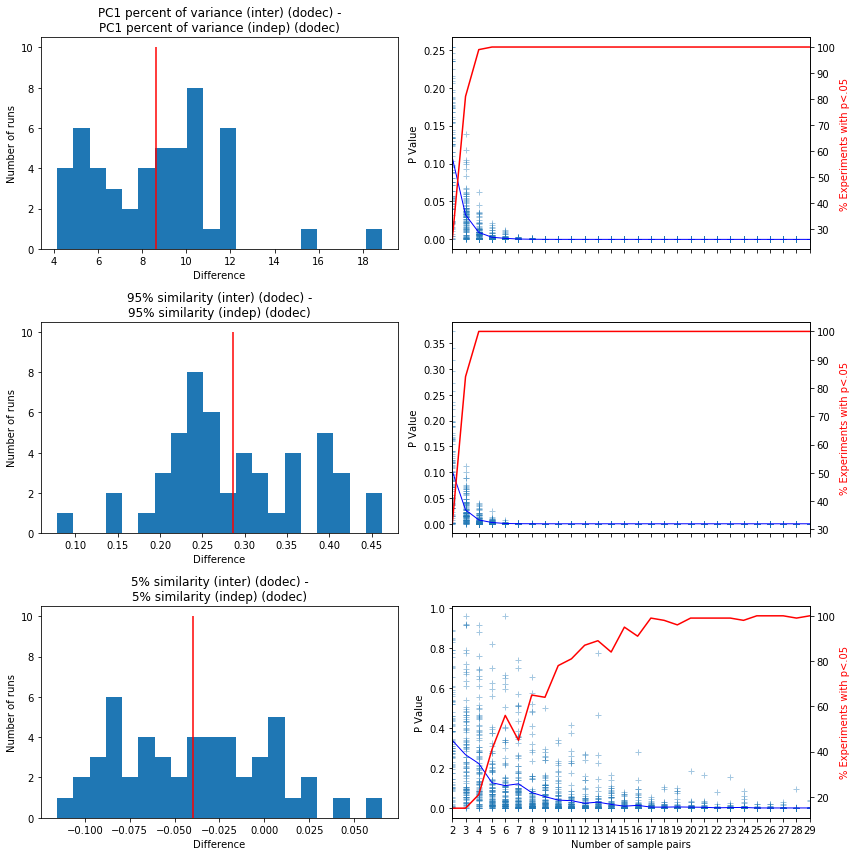

In [31]:
# basic measures
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['95% similarity (inter) (dodec)', '95% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs1,
         measures=['5% similarity (inter) (dodec)', '5% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

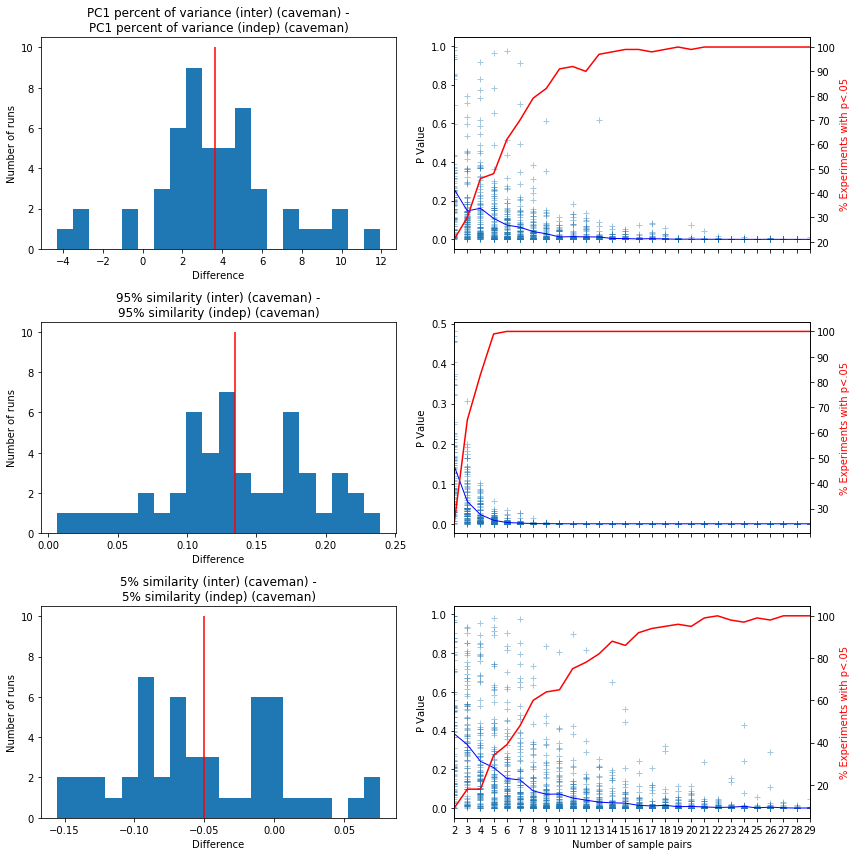

In [32]:
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['PC1 percent of variance (inter) (caveman)', 'PC1 percent of variance (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['95% similarity (inter) (caveman)', '95% similarity (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs1,
         measures=['5% similarity (inter) (caveman)', '5% similarity (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

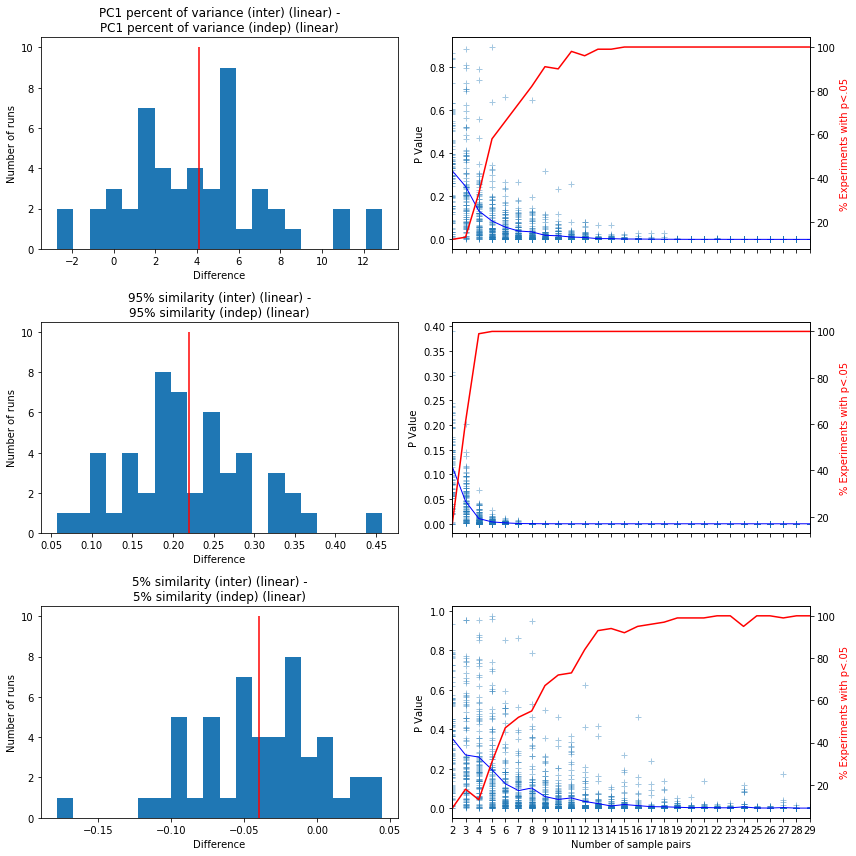

In [33]:
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['PC1 percent of variance (inter) (linear)', 'PC1 percent of variance (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['95% similarity (inter) (linear)', '95% similarity (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs1,
         measures=['5% similarity (inter) (linear)', '5% similarity (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

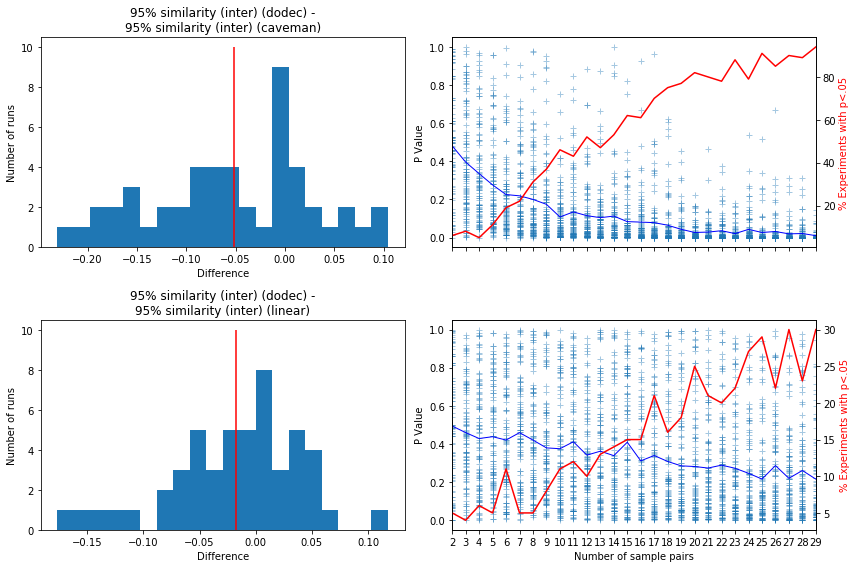

In [34]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['95% similarity (inter) (dodec)', '95% similarity (inter) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['95% similarity (inter) (dodec)', '95% similarity (inter) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

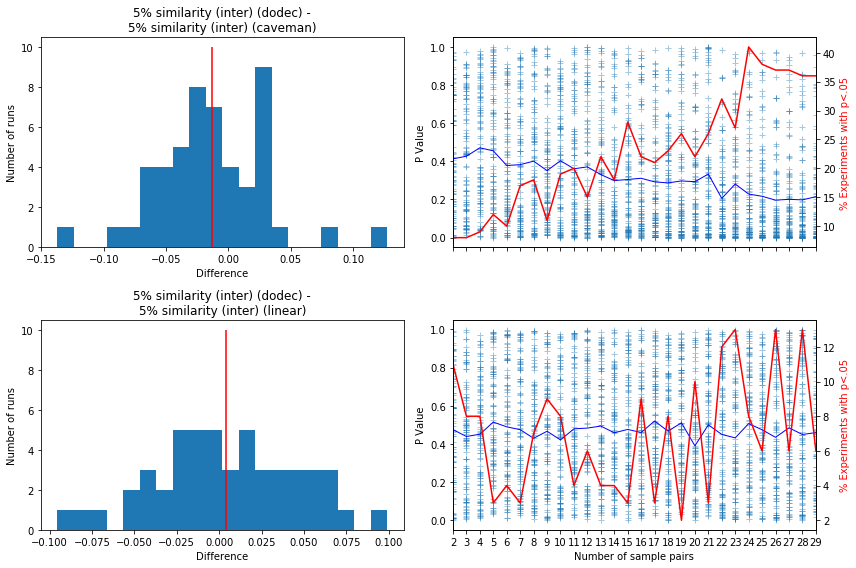

In [35]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['5% similarity (inter) (dodec)', '5% similarity (inter) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['5% similarity (inter) (dodec)', '5% similarity (inter) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

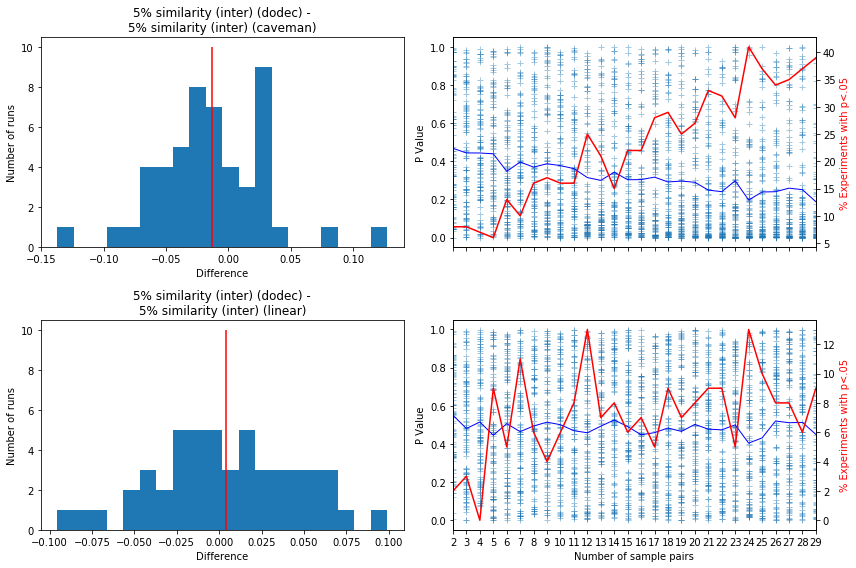

In [36]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['5% similarity (inter) (dodec)', '5% similarity (inter) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['5% similarity (inter) (dodec)', '5% similarity (inter) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

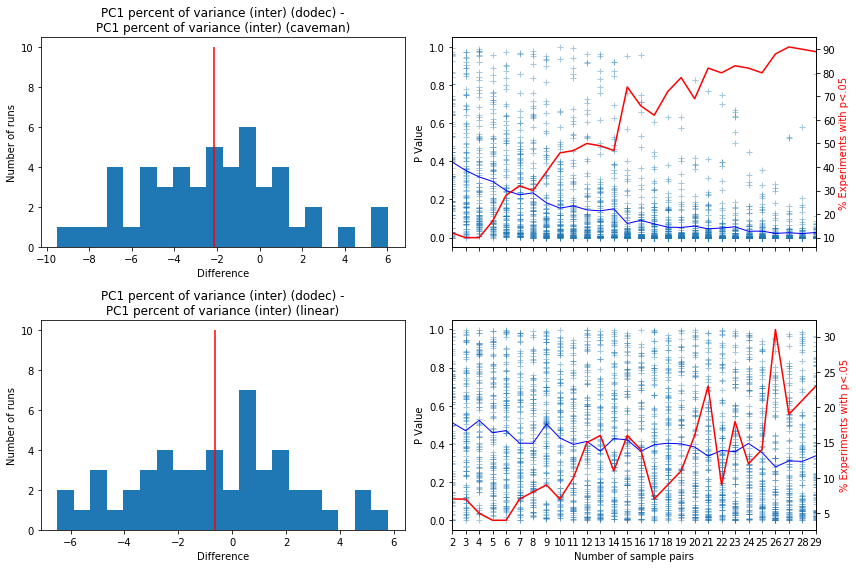

In [37]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (inter) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (inter) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

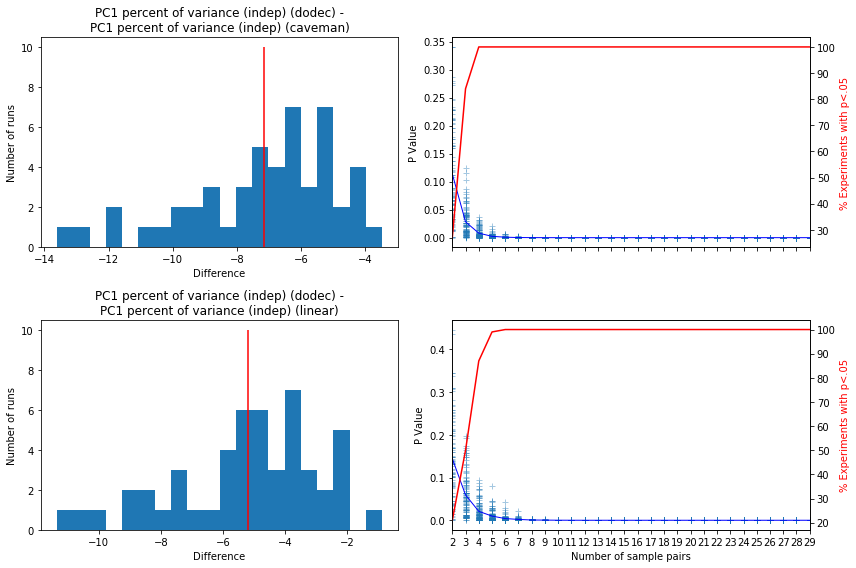

In [38]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs1,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs1,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

# measure only spoke beliefs
In the experiment we are only taking measures on 'spoke' beliefs, which cuts down the resolution still further. How many samples do we need to get a result with this modification?

In [39]:
def model_2():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
        if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
            return g.nodes[agent]['S'].has_edge(*belief)
        else:  # interdependent case
            try:
                return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                return False  # no path exists between the nodes

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
        #################CHANGES###############
        #measure a specific subset of beliefs
        beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
        ########################################
        
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
    
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))

        # calculate the population likelihood of being susceptible to a given (non-held) belief
        p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
             (1 - res1.loc[0, '% adopted']))

        # choose a set of beliefs for each agent to be susceptible to
        new_sus = {}
        for agent in g2:
            gc = copy.deepcopy(beliefs)  # potentially susceptible to any belief
            gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
            # from remainder, randomly select a subset of beliefs to be susceptible to
            edges = list(itertools.compress(
                list(gc.edges()),  # selection candidates
                np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
            ))
            edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
            new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

        nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs = 13  # Has to be big enough for contagion to take place
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    return pd.concat((res, resc, resl), axis=1)

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                         suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame


    
#model_2().T


In [40]:
runs2 = pd.concat([model_2().iloc[-1] for _ in range(n_runs)], axis=1).T
runs2.head().T

,10,10,10,10,10
% susceptible (inter) (dodec),0.729545,0.743182,0.752273,0.770455,0.752273
% adopted (inter) (dodec),0.663636,0.681818,0.697727,0.761364,0.645455
95% similarity (inter) (dodec),0.732695,0.677296,0.671535,0.516398,0.732695
5% similarity (inter) (dodec),-0.323664,-0.339324,-0.126636,-0.288675,0.078863
PC1 percent of variance (inter) (dodec),33.249423,37.329959,30.007058,25.483970,27.465218
% susceptible (indep) (dodec),0.747727,0.765909,0.754545,0.784091,0.747727
% adopted (indep) (dodec),0.706818,0.731818,0.713636,0.775000,0.668182
95% similarity (indep) (dodec),0.482353,0.437042,0.437042,0.383204,0.526482
5% similarity (indep) (dodec),-0.178605,-0.196705,-0.171422,-0.309470,-0.075482
PC1 percent of variance (indep) (dodec),18.663006,17.526375,17.845189,18.217336,17.671427


In [41]:
make_table(runs2, samples_needed)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,1000.0,1000.0,135.0,1000.0,1000.0
95% similarity,4.0,5.0,4.0,24.0,5.0
PC1 percent of variance,6.0,8.0,5.0,17.0,5.0


In [42]:
make_table(runs2, effect_size)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,-0.009614,0.019650,-0.034301,0.007277,-0.006975
95% similarity,0.255753,0.125246,0.261101,0.059127,0.251004
PC1 percent of variance,15.418524,5.805447,13.805004,3.074380,14.312323


In [43]:
make_table(runs2, confidence)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,0.06,0.26,0.253333,0.106667,0.06
95% similarity,1.00,1.00,1.000000,0.993333,1.00
PC1 percent of variance,1.00,1.00,1.000000,1.000000,1.00


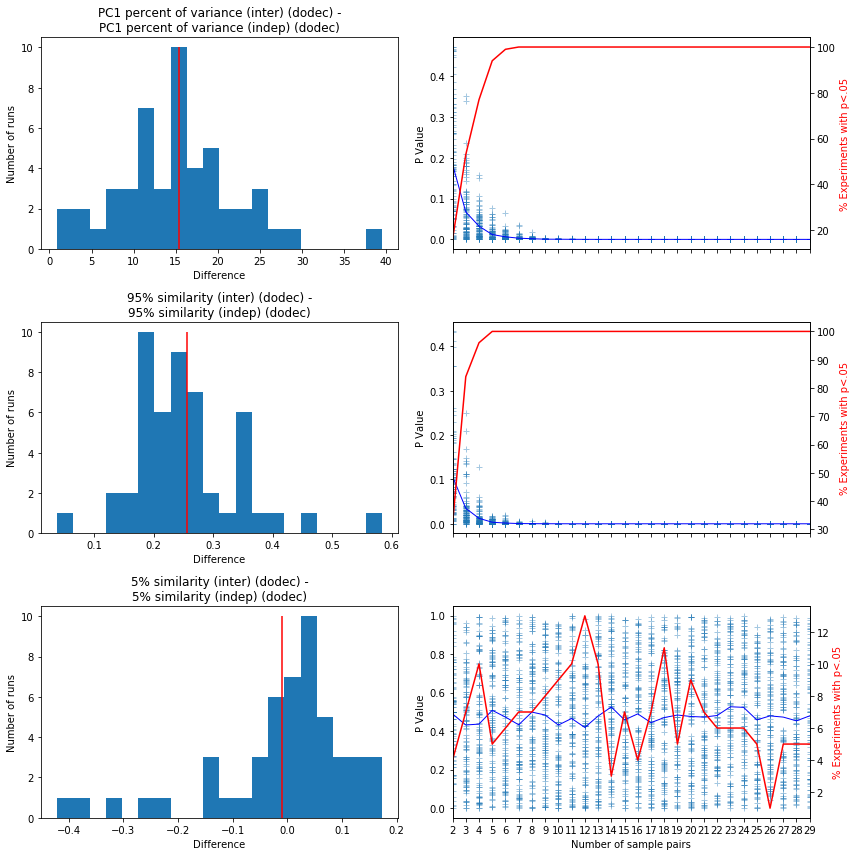

In [44]:
# basic measures
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs2,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs2,
         measures=['95% similarity (inter) (dodec)', '95% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs2,
         measures=['5% similarity (inter) (dodec)', '5% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

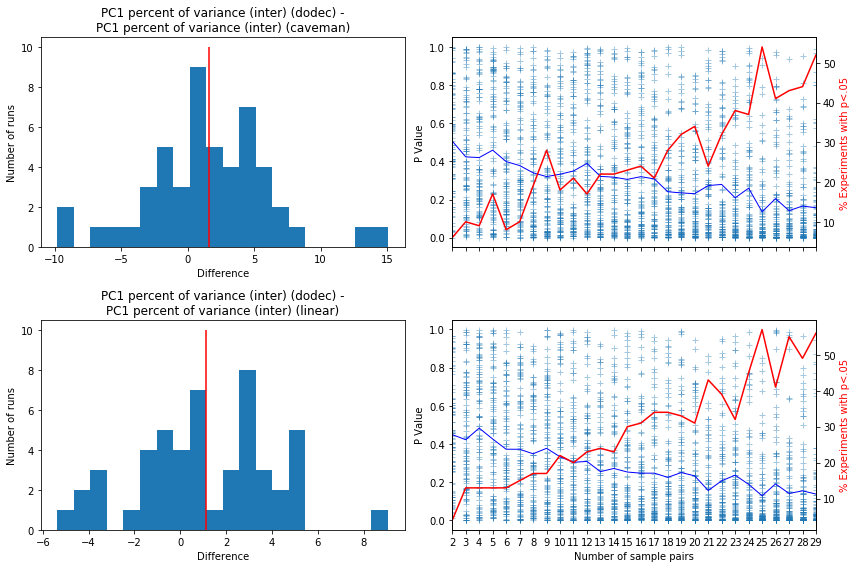

In [45]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs2,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (inter) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs2,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (inter) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

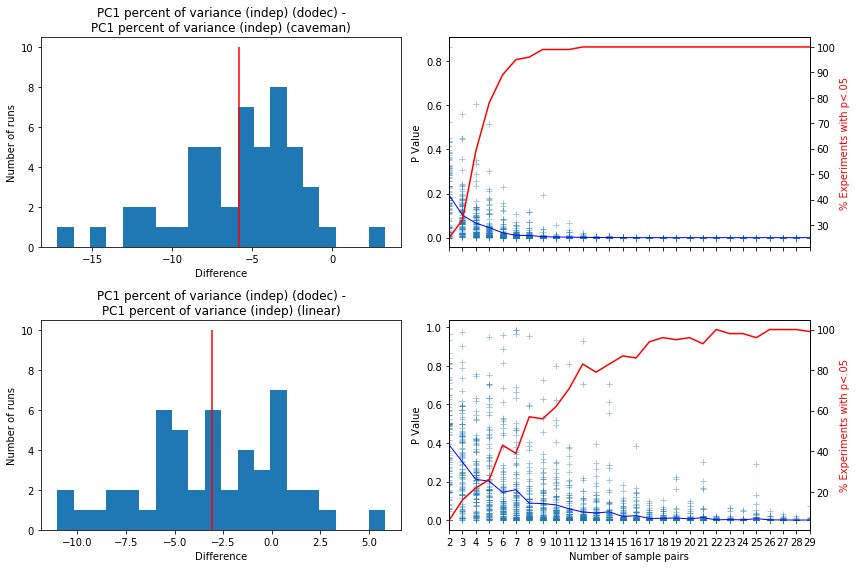

In [46]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs2,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs2,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

# stochastic behavior rule

This isn't an actual decision rule, it's just a plausible alternative that accounts for a base rate and familiarity

This compares a plausible outcome of the treatment case with the idealized control case. If this shows an effect, but the next doesn't it means that our control case is not good enough.

In [47]:
def model_3():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
        if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
            return g.nodes[agent]['S'].has_edge(*belief)
        else:  # interdependent case
############ Changes ############
            q = .975 # probability of not getting adopted
            try:
                if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                    q *= .5
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                # no path exists between the nodes
                pass

        familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
        q *= .975**familiarity

        adopt =  np.random.binomial(1, p=1-q) == 1
#################
        return adopt

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps, measure_times):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
#################CHANGES###############
        #measure a specific subset of beliefs
        beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
########################################
        
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
    
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        res1 = simulate(g1, n_steps, measure_times=[0,n_steps])

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))

        # calculate the population likelihood of being susceptible to a given (non-held) belief
        p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
             (1 - res1.loc[0, '% adopted']))

        # choose a set of beliefs for each agent to be susceptible to
        new_sus = {}
        for agent in g2:
            gc = copy.deepcopy(beliefs)  # potentially susceptible to any belief
            gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
            # from remainder, randomly select a subset of beliefs to be susceptible to
            edges = list(itertools.compress(
                list(gc.edges()),  # selection candidates
                np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
            ))
            edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
            new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

        nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
        res2 = simulate(g2, n_steps, measure_times=[0,n_steps])  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
####### Changes
    n_beliefs = 4  # Has to be big enough for contagion to take place
#######
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    return pd.concat((res, resc, resl), axis=1)

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                         suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame


    
model_3().T


,0,10
% susceptible (inter) (dodec),0.106818,6.204545e-01
% adopted (inter) (dodec),0.070455,5.204545e-01
95% similarity (inter) (dodec),0.464740,8.229433e-01
5% similarity (inter) (dodec),-0.126827,1.825742e-01
PC1 percent of variance (inter) (dodec),22.577144,2.353873e+01
% susceptible (indep) (dodec),0.640909,6.409091e-01
% adopted (indep) (dodec),0.070455,4.090909e-01
95% similarity (indep) (dodec),0.464740,6.383106e-01
5% similarity (indep) (dodec),-0.126827,-9.283444e-03
PC1 percent of variance (indep) (dodec),22.577144,1.886098e+01


In [48]:
n_runs=50
runs3 = pd.concat([model_3().iloc[-1] for _ in range(n_runs)], axis=1).T
runs3.head().T

,10,10,10,10,10
% susceptible (inter) (dodec),0.452273,0.429545,0.331818,0.613636,0.588636
% adopted (inter) (dodec),0.263636,0.245455,0.204545,0.481818,0.497727
95% similarity (inter) (dodec),0.911465,0.817050,0.793884,0.832050,0.874105
5% similarity (inter) (dodec),0.208170,-0.001726,-0.118345,0.258775,0.310983
PC1 percent of variance (inter) (dodec),45.211036,33.979363,32.949191,28.877375,27.157958
% susceptible (indep) (dodec),0.447727,0.488636,0.381818,0.622727,0.604545
% adopted (indep) (dodec),0.084091,0.222727,0.100000,0.406818,0.336364
95% similarity (indep) (dodec),0.690285,0.715482,1.000000,0.677296,0.709958
5% similarity (indep) (dodec),-0.104008,-0.053836,-0.133631,-0.027195,0.040996
PC1 percent of variance (indep) (dodec),30.288957,22.866082,44.026437,28.061972,23.026026


In [49]:
make_table(runs3, samples_needed)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,13.0,14.0,10.0,21.0,1000.0
95% similarity,11.0,140.0,19.0,1000.0,10.0
PC1 percent of variance,10.0,30.0,9.0,18.0,7.0


In [50]:
make_table(runs3, effect_size)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,0.169409,-0.104427,-0.163097,-0.122220,-0.045898
95% similarity,0.141912,-0.023750,0.105832,-0.011631,0.136840
PC1 percent of variance,7.815525,3.858077,13.791356,6.186665,17.441495


In [51]:
make_table(runs3, confidence)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,1.0,1.00,1.0,1.000000,0.286667
95% similarity,1.0,0.32,1.0,0.113333,1.000000
PC1 percent of variance,1.0,0.94,1.0,0.980000,1.000000


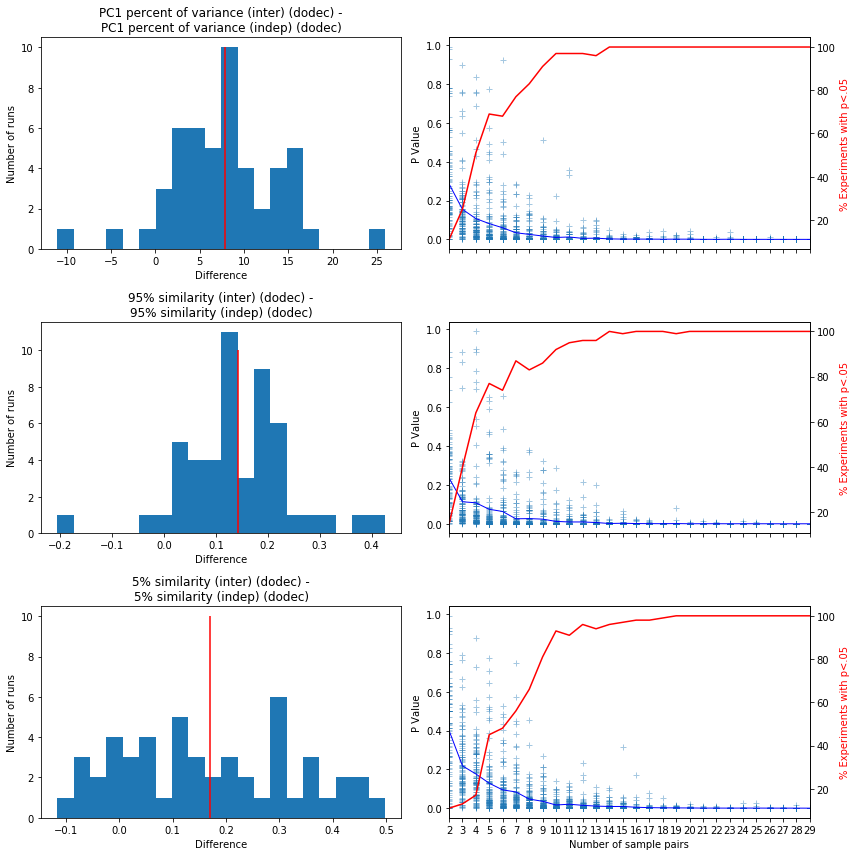

In [52]:
# basic measures
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs3,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs3,
         measures=['95% similarity (inter) (dodec)', '95% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs3,
         measures=['5% similarity (inter) (dodec)', '5% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

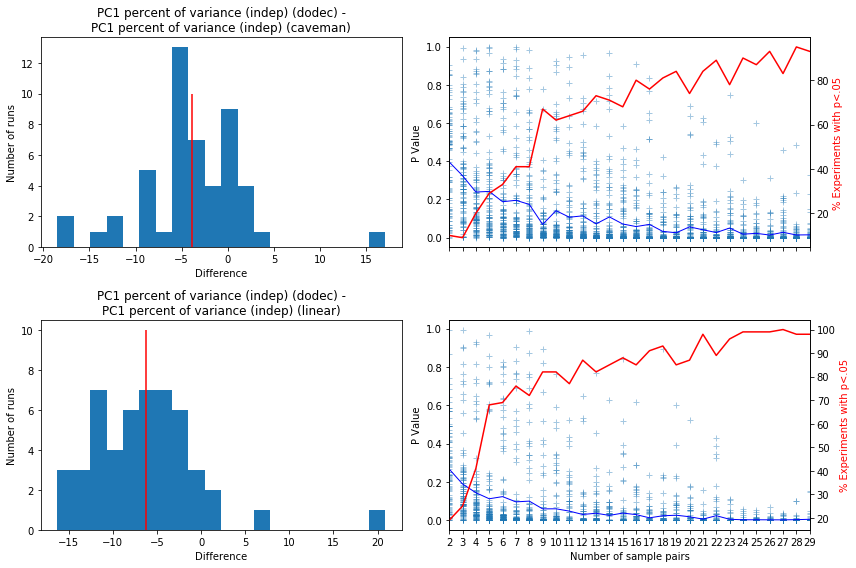

In [53]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs3,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs3,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

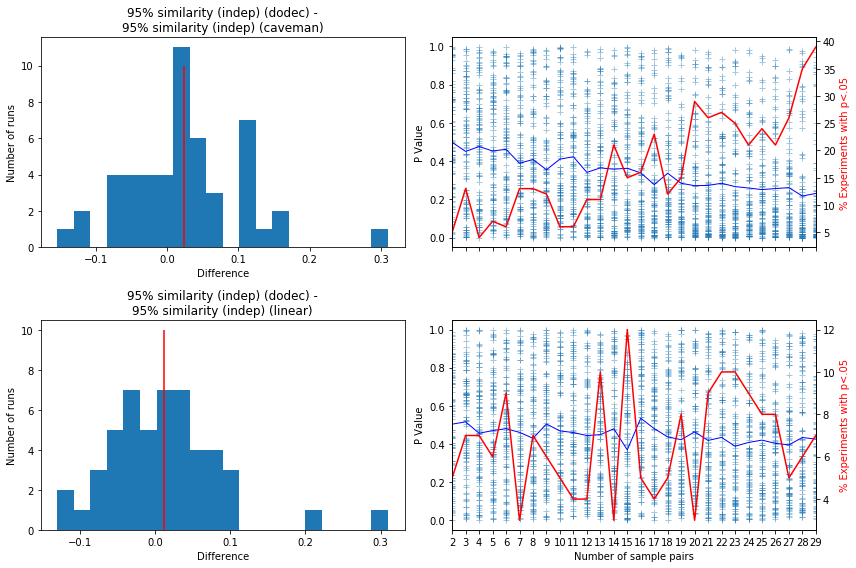

In [54]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs3,
         measures=['95% similarity (indep) (dodec)', '95% similarity (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs3,
         measures=['95% similarity (indep) (dodec)', '95% similarity (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

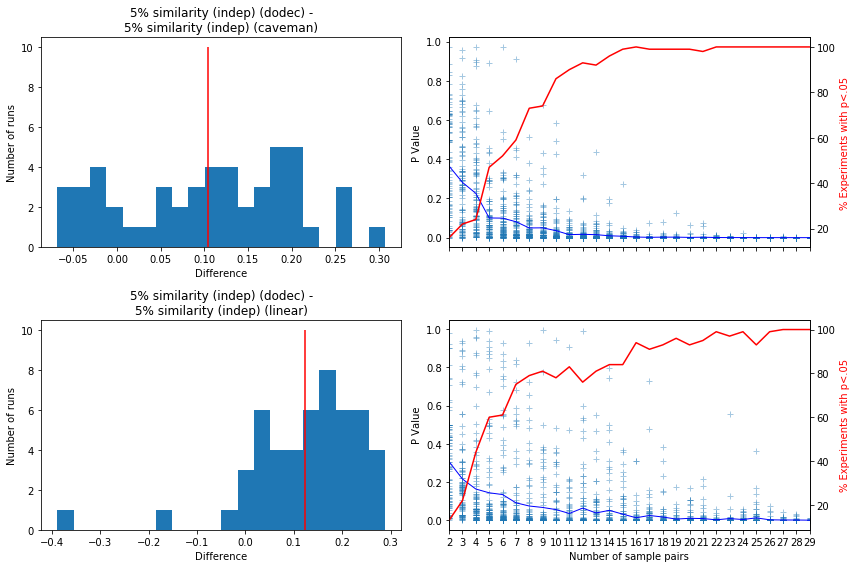

In [55]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs3,
         measures=['5% similarity (indep) (dodec)', '5% similarity (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs3,
         measures=['5% similarity (indep) (dodec)', '5% similarity (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

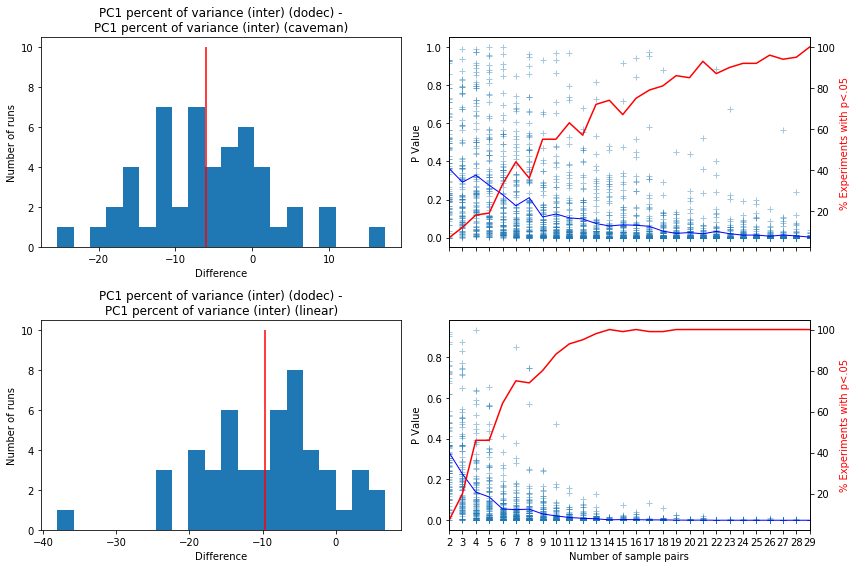

In [56]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs3,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (inter) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs3,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (inter) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

# Experiment Manipulation
In the actual experiment, we can't force independence. 

In [57]:
def model_4():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
############ Changes ############
        q = .975 # probability of not getting adopted
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q *= .5
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            pass

        familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
        q *= .975**familiarity

        adopt =  np.random.binomial(1, p=1-q) == 1
#################
        return adopt

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
#################CHANGES###############
        #measure a specific subset of beliefs
        beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
########################################
        
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
   
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))
        
######Changes
        core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
        i = 13
        control_edges = copy.deepcopy(core_edges)
        for n in range (2, 13):
            for s in range(5):
                control_edges.append((n,i))
                i += 1

        control_beliefs = nx.from_edgelist(control_edges) 
        core_network = nx.from_edgelist(core_edges)

        for agent in g2:
            new_edges = []
            for edge in g2.nodes[agent]['M'].edges():
                if control_beliefs.has_edge(*edge):
                    new_edges.append(edge)
                else:
                    end = np.random.choice(edge)
                    options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                    new_edges.append(options[np.random.randint(len(options))])

            g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
########
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
####### Changes
    n_beliefs = 4
#######
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    return pd.concat((res, resc, resl), axis=1)

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                         suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame


    
model_4().T


,0,10
% susceptible (inter) (dodec),0.084091,0.488636
% adopted (inter) (dodec),0.052273,0.320455
95% similarity (inter) (dodec),0.690066,0.900423
5% similarity (inter) (dodec),-0.100000,0.350855
PC1 percent of variance (inter) (dodec),22.536852,25.742926
% susceptible (indep) (dodec),0.061364,0.152273
% adopted (indep) (dodec),0.052273,0.104545
95% similarity (indep) (dodec),0.690066,0.842927
5% similarity (indep) (dodec),-0.100000,-0.125656
PC1 percent of variance (indep) (dodec),22.536852,30.734960


In [58]:
runs4 = pd.concat([model_4().iloc[-1] for _ in range(n_runs)], axis=1).T
runs4.head().T

,10,10,10,10,10
% susceptible (inter) (dodec),0.456818,0.579545,0.577273,0.550000,0.565909
% adopted (inter) (dodec),0.322727,0.468182,0.422727,0.527273,0.540909
95% similarity (inter) (dodec),0.721536,0.816667,1.000000,0.912871,0.725797
5% similarity (inter) (dodec),-0.239046,0.204124,0.349792,0.500298,0.112692
PC1 percent of variance (inter) (dodec),32.303959,26.245273,33.397879,29.632904,25.449611
% susceptible (indep) (dodec),0.175000,0.125000,0.106818,0.268182,0.122727
% adopted (indep) (dodec),0.188636,0.120455,0.075000,0.220455,0.147727
95% similarity (indep) (dodec),0.732695,0.608710,0.690066,0.690066,0.585060
5% similarity (indep) (dodec),-0.193499,-0.193649,-0.125656,-0.187317,-0.271040
PC1 percent of variance (indep) (dodec),23.234806,28.763112,23.702487,27.452638,27.768402


In [59]:
make_table(runs4, samples_needed)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,8.0,1000.0,1000.0,1000.0,53.0
95% similarity,7.0,1000.0,6.0,1000.0,6.0
PC1 percent of variance,42.0,28.0,9.0,1000.0,7.0


In [60]:
make_table(runs4, effect_size)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,0.292947,-0.001048,-0.011634,-0.00538,0.084589
95% similarity,0.172111,0.017352,0.129001,-0.00026,0.173366
PC1 percent of variance,3.728636,3.697283,9.723121,1.21421,14.537557


In [61]:
make_table(runs4, confidence)

,(inter) (dodec),(indep) (caveman),(inter) (caveman),(indep) (linear),(inter) (linear)
5% similarity,1.000000,0.046667,0.213333,0.146667,0.773333
95% similarity,1.000000,0.233333,1.000000,0.033333,1.000000
PC1 percent of variance,0.713333,0.953333,1.000000,0.326667,1.000000


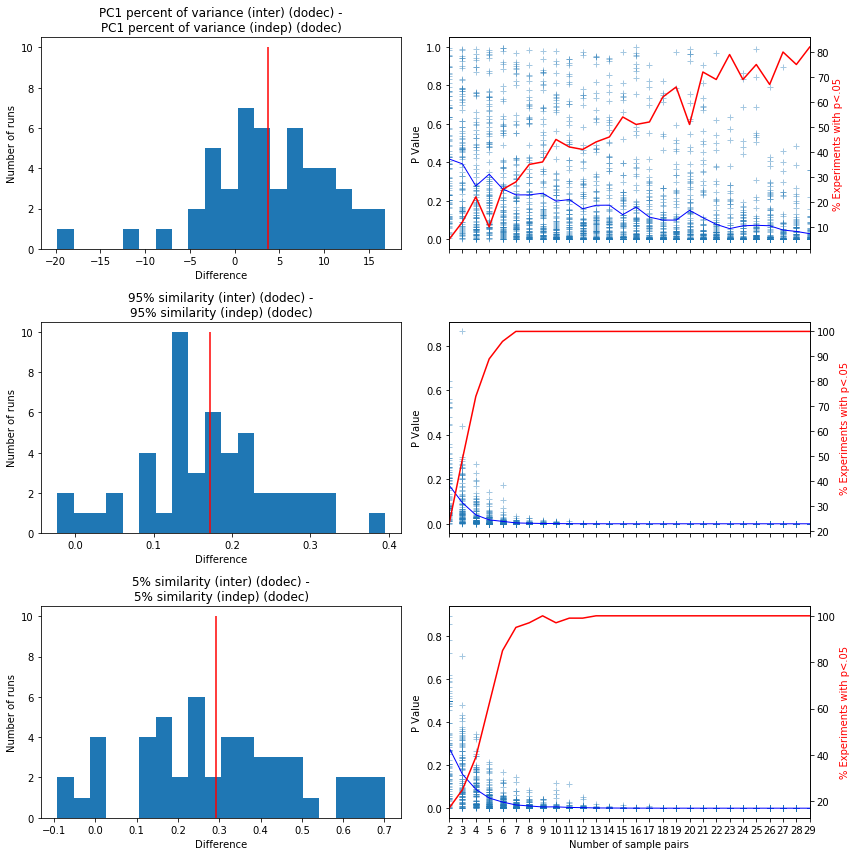

In [62]:
# basic measures
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs4,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs4,
         measures=['95% similarity (inter) (dodec)', '95% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs4,
         measures=['5% similarity (inter) (dodec)', '5% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

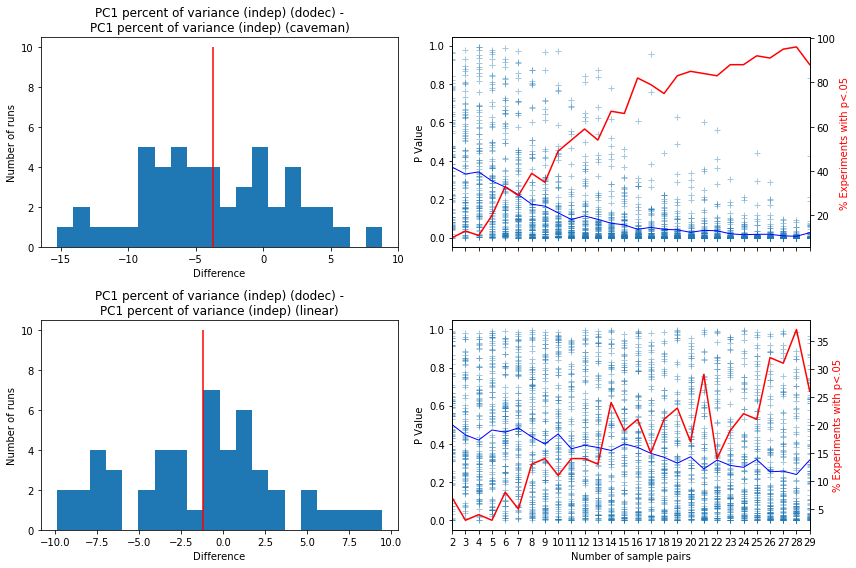

In [63]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs4,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs4,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

In [ ]:
# core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]

# i = 13
# control_edges = copy.deepcopy(core_edges)
# for n in range (2, 13):
#     for s in range(5):
#         control_edges.append((n,i))
#         i += 1
    
# control_beliefs = nx.from_edgelist(control_edges) 
# core_network = nx.from_edgelist(core_edges)
# #nx.draw_networkx(control_beliefs)
# nx.draw_networkx(core_network)

# def susceptible(g, agent, belief):
#     """Assess whether an agent is susceptible to a given belief"""
#     if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
#         return g.nodes[agent]['S'].has_edge(*belief)
#     else:  # interdependent case
#         try:
#             if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
#                 q = .75
#             else:
#                 q = .025 # base hazard
#         except (nx.NetworkXNoPath, nx.NodeNotFound):
#             # no path exists between the nodes
#             q = .025 # base hazard
    
#     familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
#     q *= 1.25**familiarity
    
#     adopt =  np.random.binomial(1, np.tanh(q)) == 1
#     #print(adopt)
#     return adopt
        
# def adopt(g, agent, belief):
#     """Assess whether an agent will adopt a given belief"""
#     suscep = susceptible(g, agent, belief)
#     exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
#     return suscep and exposed  # both susceptibility and exposure required to adopt        

# def simulate(g, n_steps=10):
#     """Conduct a single run of the simulation with a given network"""
#     # capture a list of all the beliefs in the population
#     beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

#     m = [measure(g, beliefs)]  # array to collect measurements at each time step
#     ts = [0]
#     for step in range(n_steps):  # perform the simulation
#         for ego in np.random.permutation(g):  # cycle through agents in random order
#             for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
#                 if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
#                     g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

#         m.append(measure(g, beliefs))  # ignore returned init suscep and adopt
#         ts.append(step+1)
        
#     df = pd.DataFrame(m, index=ts)
#     return df


# def measure(g, beliefs):
#     """Take measurements of the state of the system (for creating figures)"""
    
#     beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), 
#                (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
    
#     res = {}  # dictionary to collect measurements

#     # build a matrix of who (rows) is susceptible to what beliefs (columns)
#     suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
#     for agent in g:
#         for belief in suscep.columns:
#             suscep.at[agent, belief] = susceptible(g, agent, belief)
#     res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

#     # build a matrix of who (rows) holds what beliefs (columns)
#     adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
#     for agent in g:
#         for belief in adopt.columns:
#             adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
#     res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


#     n_agents = len(adopt.index)
#     corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
#     res['95% similarity'] = np.percentile(corrs, 95)
#     res['5% similarity'] = np.percentile(corrs, 5)

#     # Fig 5B: PC1 percent variance
#     # ----------------------------
#     pca = PCA(n_components=1)
#     pca.fit(adopt)
#     res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100
    
    # need to repeat and take averages, or we're just comparing to a different noisy signal
#     e95 = []
#     e5 = []
#     ePC1 = []
#     for _ in range(100):
#         shuffle_adopt = pd.DataFrame()
#         for col in adopt.columns:
#             shuffle_adopt[col] = np.random.permutation(adopt[col].values)

#         n_agents = len(shuffle_adopt.index)
#         corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
#         e95.append(np.percentile(corrs, 95))
#         e5.append(np.percentile(corrs, 5))

#         pca = PCA(n_components=1)
#         pca.fit(shuffle_adopt)
#         ePC1.append(pca.explained_variance_ratio_[0] * 100)
        
#     res['expected PC1 percent of variance'] = np.mean(ePC1)
#     res['expected 95% similarity'] = np.mean(e95)
#     res['expected 5% similarity'] = np.mean(e5)
    
#     res['net expected PC1 percent of variance'] = res['PC1 percent of variance'] - res['expected PC1 percent of variance']
#     res['net 95% similarity'] = res['95% similarity'] - res['expected 95% similarity']  
#     res['net 5% similarity'] = res['5% similarity'] - res['expected 5% similarity']  
#     return res

# def run(n_steps=10):
#     """Run a matched pair of simulations (inter/independent) from the same initial condition

#     Parameters
#     ----------
#     n_agents: (integer) - Number of agents in the population
#     deg: (integer) - How many neighbors each agent has (on average)
#     n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
#     n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
#     t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
#                                         must be less than or equal to n_steps
#     n_steps: (integer) - Number of time steps in the simulation
#     """
#     g0 = nx.dodecahedral_graph()
    
# # Connected Caveman
# #     edgelist = [(0,1), (0,2), (0,3),
# #             (1,2), (1,3),
# #             (2,7),
# #             (4,5), (4,6), (4,7),
# #             (5,6), (5,7),
# #             (6,11),
# #             (8,9), (8,10), (8,11),
# #             (9,10), (9,11),
# #             (10,15),
# #             (12,13), (12,14), (12,15),
# #             (13,14), (13,15),
# #             (14,19),
# #             (16,17), (16,18), (16,19),
# #             (17,18), (17,19),
# #             (18,3)]

#     # cube/ladder
#     edgelist = [(0,1), (1,2), (2,3), (3,0),
#                 (0,4), (1,5), (2,6), (3,7),
#                 (4,5), (5,6), (4,7),
#                 (6,8), (7,9), (8,9),
#                 (8,10), (9,11), (10,11),
#                 (10,12), (11,13),
#                 (12,14), (14,15), (15,13),
#                 (12,16), (14,17), (15,18), (13,19),
#                 (16,19), (16,17), (17,18), (18,19)
#     ]
#     g0c = nx.from_edgelist(edgelist)
    
    
#     n_concepts=13
#     n_beliefs=4
#     beliefs = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
#     # give agents their initial beliefs in dodec network
#     nx.set_node_attributes(
#         g0,
#         name='M',  # set node attribute 'M' (for 'mind')
#         # create a semantic network with a different random set of beliefs
#         # for each agent, and assign to nodes in the social network
#         values = beliefs
#     )
    
#     # give agents their initial beliefs in caveman network
#     nx.set_node_attributes(
#         g0c,
#         name='M',  # set node attribute 'M' (for 'mind')
#         # create a semantic network with a different random set of beliefs
#         # for each agent, and assign to nodes in the social network
#         values = beliefs
#     )

#     ######### dodec network ########
#     # Treatment simulation
#     # --------------------
#     g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
#     res1 = simulate(g1, n_steps)

#     # Control simulation
#     # ------------------
#     g2 = copy.deepcopy(g0)  # copy from original starting conditions
#     # give spoke and spur beliefs
#     for agent in g2:
#         new_edges = []
#         for edge in g2.nodes[agent]['M'].edges():
#             if control_beliefs.has_edge(*edge):
#                 new_edges.append(edge)
#             else:
#                 end = np.random.choice(edge)
#                 options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
#                 new_edges.append(options[np.random.randint(len(options))])
                
#         g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
#     res2 = simulate(g2, n_steps)  # perform simulation
    
#     res = pd.merge(res1, res2, left_index=True, right_index=True,
#                     suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame
    
#     ########## caveman network #########
#     # Treatment simulation
#     # --------------------
#     g1c = copy.deepcopy(g0c)  # create copy, to preserve initial conditions for other case
#     res1c = simulate(g1c, n_steps)

#     # Control simulation
#     # ------------------
#     g2c = copy.deepcopy(g0c)  # copy from original starting conditions
#     # give spoke and spur beliefs
#     for agent in g2c:
#         new_edges = []
#         for edge in g2c.nodes[agent]['M'].edges():
#             if control_beliefs.has_edge(*edge):
#                 new_edges.append(edge)
#             else:
#                 end = np.random.choice(edge)
#                 options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
#                 new_edges.append(options[np.random.randint(len(options))])
                
#         g2c.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
#     res2c = simulate(g2c, n_steps)  # perform simulation
    
#     resc = pd.merge(res1c, res2c, left_index=True, right_index=True,
#                     suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                     suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame



# n_runs=250
# runs4 = pd.concat([
#     run().iloc[-1] 
#     for _ in range(n_runs)], 
#     axis=1).T



# runs4.dropna(inplace=True)
# n_runs=len(runs4)

# runs4.head()

# Compare to Expected
When one condition has different gross levels of diffusion than the other (which can happen just by chance, as differences in reponse rates between groups are amplified by the contagion process) then we mix the effect of extent of diffusion with the effect of interdependence. In large sample sizes this cancels out, but we can improve our statistical efficiency by comparing to the expected values for a given level of diffusion.

In [64]:
def model_5():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
############ Changes ############
        q = .975 # probability of not getting adopted
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q *= .5
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            pass

        familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
        q *= .975**familiarity

        adopt =  np.random.binomial(1, p=1-q) == 1
#################
        return adopt

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
#################CHANGES###############
        #measure a specific subset of beliefs
        beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
########################################
        
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

###### Changes
        # Measure difference from expected value
        e95 = []
        e5 = []
        ePC1 = []
        for _ in range(100):
            shuffle_adopt = pd.DataFrame()
            for col in adopt.columns:
                shuffle_adopt[col] = np.random.permutation(adopt[col].values)

            n_agents = len(shuffle_adopt.index)
            corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
            e95.append(np.percentile(corrs, 95))
            e5.append(np.percentile(corrs, 5))

            pca = PCA(n_components=1)
            pca.fit(shuffle_adopt)
            ePC1.append(pca.explained_variance_ratio_[0] * 100)

        res['expected PC1 percent of variance'] = np.mean(ePC1)
        res['expected 95% similarity'] = np.mean(e95)
        res['expected 5% similarity'] = np.mean(e5)

        res['net PC1 percent of variance'] = res['PC1 percent of variance'] - res['expected PC1 percent of variance']
        res['net 95% similarity'] = res['95% similarity'] - res['expected 95% similarity']  
        res['net 5% similarity'] = res['5% similarity'] - res['expected 5% similarity']
#########
        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
   
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))
        
######Changes
        core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
        i = 13
        control_edges = copy.deepcopy(core_edges)
        for n in range (2, 13):
            for s in range(5):
                control_edges.append((n,i))
                i += 1

        control_beliefs = nx.from_edgelist(control_edges) 
        core_network = nx.from_edgelist(core_edges)

        for agent in g2:
            new_edges = []
            for edge in g2.nodes[agent]['M'].edges():
                if control_beliefs.has_edge(*edge):
                    new_edges.append(edge)
                else:
                    end = np.random.choice(edge)
                    options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                    new_edges.append(options[np.random.randint(len(options))])

            g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
########
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
####### Changes
    n_beliefs = 4
#######
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    return pd.concat((res, resc, resl), axis=1)

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                         suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame


    
res = model_5().T
res


,0,10
% susceptible (inter) (dodec),0.104545,0.525000
% adopted (inter) (dodec),0.070455,0.418182
95% similarity (inter) (dodec),0.597830,0.816667
5% similarity (inter) (dodec),-0.125656,0.158424
PC1 percent of variance (inter) (dodec),21.653472,23.429781
...,...,...
expected 95% similarity (indep) (linear),0.598117,0.603837
expected 5% similarity (indep) (linear),-0.137186,-0.176656
net PC1 percent of variance (indep) (linear),-0.162505,5.766300
net 95% similarity (indep) (linear),-0.000287,0.066984


In [65]:
runs5 = pd.concat([model_5().iloc[-1] for _ in range(n_runs)], axis=1).T
runs5.head().T

,10,10,10,10,10
% susceptible (inter) (dodec),0.575000,0.513636,0.513636,0.522727,0.575000
% adopted (inter) (dodec),0.468182,0.395455,0.304545,0.488636,0.522727
95% similarity (inter) (dodec),0.833333,0.910137,0.801988,0.908514,0.908514
5% similarity (inter) (dodec),0.323312,0.323306,0.004946,0.263481,0.210293
PC1 percent of variance (inter) (dodec),24.484204,30.522169,29.761452,29.362920,30.284850
...,...,...,...,...,...
expected 95% similarity (indep) (linear),0.599316,0.685616,0.604382,0.554686,0.570087
expected 5% similarity (indep) (linear),-0.192711,-0.006706,-0.185464,-0.179888,-0.204638
net PC1 percent of variance (indep) (linear),6.627660,21.326441,10.987069,3.574067,26.911490
net 95% similarity (indep) (linear),0.018426,0.199999,0.187798,0.010018,0.185842


In [98]:
make_table(runs5, samples_needed, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])

['net 95% similarity', '% adopted', '5% similarity', 'net PC1 percent of variance', '95% similarity', 'expected 5% similarity', 'net 5% similarity', 'expected PC1 percent of variance', 'PC1 percent of variance', '% susceptible', 'expected 95% similarity'] ['(inter) (caveman)', '(indep) (dodec)', '(inter) (linear)', '(indep) (linear)', '(indep) (caveman)', '(inter) (dodec)']


,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
net 95% similarity,13.0,18.0,1000.0,148.0,1000.0
5% similarity,1000.0,40.0,1000.0,1000.0,7.0
net PC1 percent of variance,14.0,11.0,1000.0,1000.0,1000.0
95% similarity,8.0,7.0,1000.0,1000.0,8.0
net 5% similarity,20.0,11.0,1000.0,1000.0,19.0
PC1 percent of variance,14.0,12.0,1000.0,1000.0,1000.0


In [97]:
make_table(runs5, effect_size, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])

['net 95% similarity', '% adopted', '5% similarity', 'net PC1 percent of variance', '95% similarity', 'expected 5% similarity', 'net 5% similarity', 'expected PC1 percent of variance', 'PC1 percent of variance', '% susceptible', 'expected 95% similarity'] ['(inter) (caveman)', '(indep) (dodec)', '(inter) (linear)', '(indep) (linear)', '(indep) (caveman)', '(inter) (dodec)']


,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
net 95% similarity,0.098564,0.073116,0.006004,0.024283,-0.002460
5% similarity,-0.006472,0.078172,0.000351,0.004086,0.318214
net PC1 percent of variance,6.457038,10.926885,0.560539,-0.229960,0.558499
95% similarity,0.122720,0.150816,0.009310,0.024063,0.173311
net 5% similarity,-0.044567,-0.100182,-0.003890,-0.000782,-0.064886
PC1 percent of variance,6.059018,10.314542,0.739754,0.266069,1.174696


In [96]:
make_table(runs5, confidence, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])

['net 95% similarity', '% adopted', '5% similarity', 'net PC1 percent of variance', '95% similarity', 'expected 5% similarity', 'net 5% similarity', 'expected PC1 percent of variance', 'PC1 percent of variance', '% susceptible', 'expected 95% similarity'] ['(inter) (caveman)', '(indep) (dodec)', '(inter) (linear)', '(indep) (linear)', '(indep) (caveman)', '(inter) (dodec)']


,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
net 95% similarity,1.000000,0.993333,0.046667,0.326667,0.066667
5% similarity,0.146667,0.846667,0.046667,0.093333,1.000000
net PC1 percent of variance,1.000000,1.000000,0.046667,0.040000,0.080000
95% similarity,1.000000,1.000000,0.053333,0.346667,1.000000
net 5% similarity,1.000000,1.000000,0.086667,0.080000,1.000000
PC1 percent of variance,1.000000,1.000000,0.046667,0.060000,0.126667


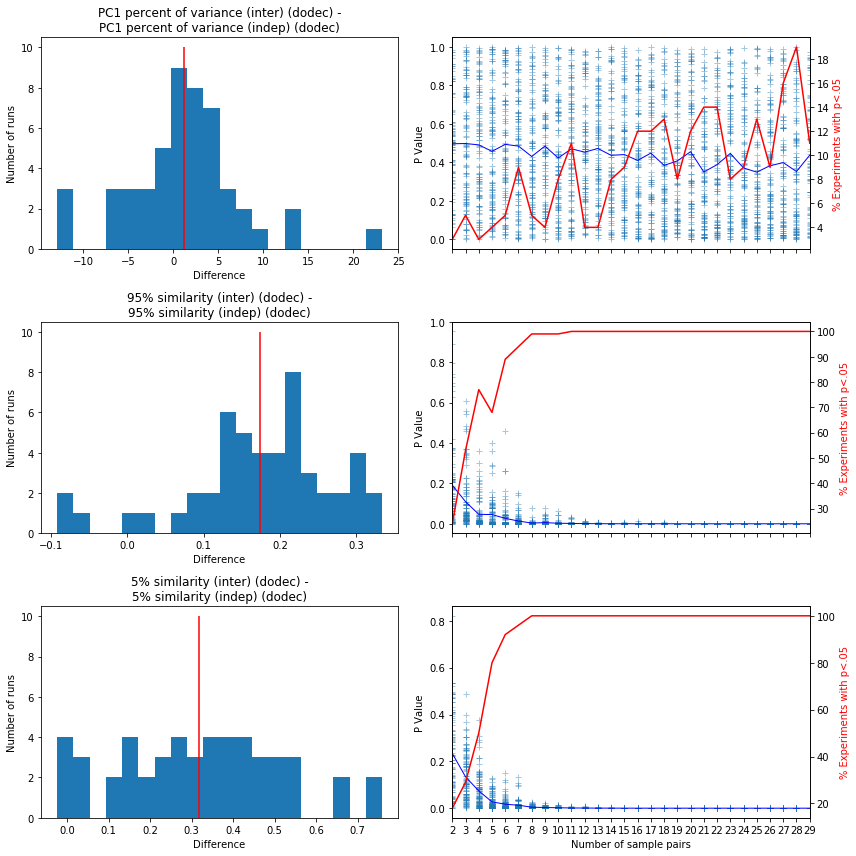

In [69]:
# basic measures
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs5,
         measures=['PC1 percent of variance (inter) (dodec)', 'PC1 percent of variance (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs5,
         measures=['95% similarity (inter) (dodec)', '95% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs5,
         measures=['5% similarity (inter) (dodec)', '5% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

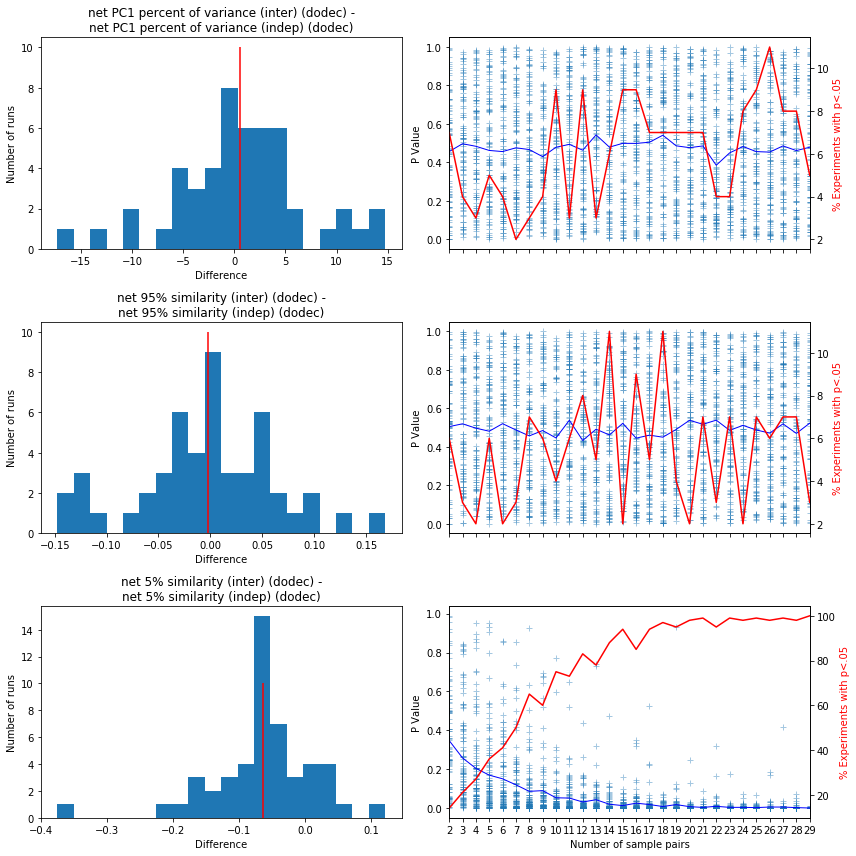

In [70]:
# basic measures
nrows = 3
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs5,
         measures=['net PC1 percent of variance (inter) (dodec)', 'net PC1 percent of variance (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs5,
         measures=['net 95% similarity (inter) (dodec)', 'net 95% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

drawfigs(runs5,
         measures=['net 5% similarity (inter) (dodec)', 'net 5% similarity (indep) (dodec)'],
         ax1=plt.subplot(nrows,ncols,5),
         ax2=plt.subplot(nrows,ncols,6))

plt.tight_layout()

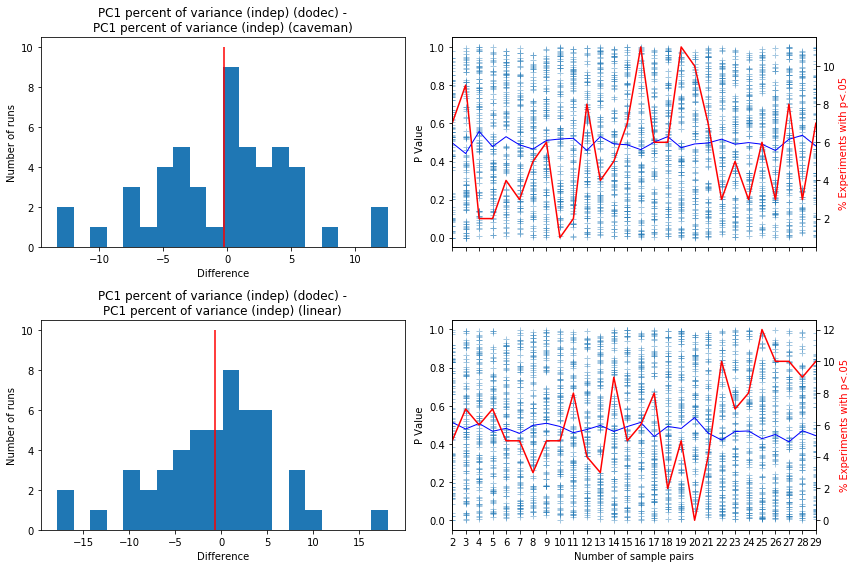

In [71]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs5,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs5,
         measures=['PC1 percent of variance (indep) (dodec)', 'PC1 percent of variance (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

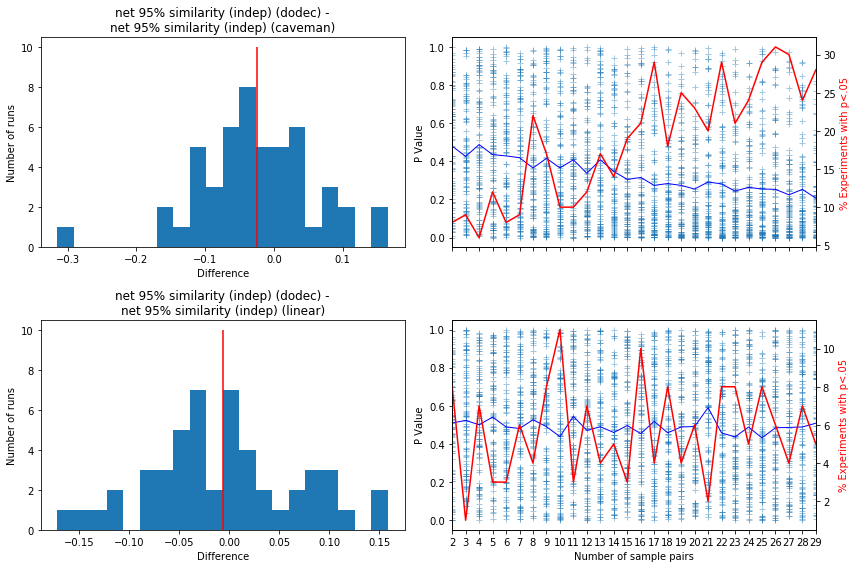

In [72]:
nrows = 2
ncols = 2

plt.figure(figsize=(6*ncols, 4*nrows))

drawfigs(runs5,
         measures=['net 95% similarity (indep) (dodec)', 'net 95% similarity (indep) (caveman)'],
         ax1=plt.subplot(nrows,ncols,1),
         ax2=plt.subplot(nrows,ncols,2))

drawfigs(runs5,
         measures=['net 95% similarity (indep) (dodec)', 'net 95% similarity (indep) (linear)'],
         ax1=plt.subplot(nrows,ncols,3),
         ax2=plt.subplot(nrows,ncols,4))

plt.tight_layout()

# Heterogeneity between individuals

In [78]:
def model_6():
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    
    
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
############ Changes ############
        q = g.nodes[agent]['q'] # probability of not getting adopted
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q *= .5
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            pass

        familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
        q *= .975**familiarity

        adopt =  np.random.binomial(1, p=1-q) == 1
#################
        return adopt

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
#################CHANGES###############
        #measure a specific subset of beliefs
        beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
########################################
        
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)
        res['90% similarity'] = np.percentile(corrs, 90)
        res['10% similarity'] = np.percentile(corrs, 10)
        res['85% similarity'] = np.percentile(corrs, 85)
        res['15% similarity'] = np.percentile(corrs, 15)
        res['80% similarity'] = np.percentile(corrs, 80)
        res['20% similarity'] = np.percentile(corrs, 20)
        res['75% similarity'] = np.percentile(corrs, 75)
        res['25% similarity'] = np.percentile(corrs, 25)        
        res['std similarity'] = np.std(corrs)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

###### Changes
        # Measure difference from expected value
        e95 = []
        e5 = []
        e10 = []
        e15 = []
        e20 = []
        e25 = []
        e75 = []
        e80 = []
        e85 = []
        e90 = []
        estd = []
        ePC1 = []
        for _ in range(100):
            shuffle_adopt = pd.DataFrame()
            for col in adopt.columns:
                shuffle_adopt[col] = np.random.permutation(adopt[col].values)

            n_agents = len(shuffle_adopt.index)
            corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
            e95.append(np.percentile(corrs, 95))
            e5.append(np.percentile(corrs, 5))
            
            e10.append(np.percentile(corrs, 10))
            e15.append(np.percentile(corrs, 15))
            e20.append(np.percentile(corrs, 20))
            e25.append(np.percentile(corrs, 25))
            e75.append(np.percentile(corrs, 75))
            e80.append(np.percentile(corrs, 80))
            e85.append(np.percentile(corrs, 85))
            e90.append(np.percentile(corrs, 90))
            estd.append(np.std(corrs))

            pca = PCA(n_components=1)
            pca.fit(shuffle_adopt)
            ePC1.append(pca.explained_variance_ratio_[0] * 100)

        res['expected PC1 percent of variance'] = np.mean(ePC1)
        res['expected 95% similarity'] = np.mean(e95)
        res['expected 5% similarity'] = np.mean(e5)
        
        res['expected 10% similarity'] = np.mean(e10)
        res['expected 15% similarity'] = np.mean(e15)
        res['expected 20% similarity'] = np.mean(e20)
        res['expected 25% similarity'] = np.mean(e25)
        res['expected 75% similarity'] = np.mean(e75)
        res['expected 80% similarity'] = np.mean(e80)
        res['expected 85% similarity'] = np.mean(e85)
        res['expected 90% similarity'] = np.mean(e90)
        res['expected std similarity'] = np.mean(estd)

        res['net PC1 percent of variance'] = res['PC1 percent of variance'] - res['expected PC1 percent of variance']
        res['net 95% similarity'] = res['95% similarity'] - res['expected 95% similarity']  
        res['net 5% similarity'] = res['5% similarity'] - res['expected 5% similarity']
        
        res['net 10% similarity'] = res['10% similarity'] - res['expected 10% similarity']
        res['net 15% similarity'] = res['15% similarity'] - res['expected 15% similarity']
        res['net 20% similarity'] = res['20% similarity'] - res['expected 20% similarity']
        res['net 25% similarity'] = res['25% similarity'] - res['expected 25% similarity']
        res['net 75% similarity'] = res['75% similarity'] - res['expected 75% similarity']
        res['net 80% similarity'] = res['90% similarity'] - res['expected 80% similarity']
        res['net 85% similarity'] = res['85% similarity'] - res['expected 85% similarity']
        res['net 90% similarity'] = res['90% similarity'] - res['expected 90% similarity']
        res['net std similarity'] = res['std similarity'] - res['expected std similarity']
#########
        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
   
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        nx.set_node_attributes(g1, name='q', values={n: np.random.beta(250, 5) for n in g1.nodes()})  # mean: .9804, std:.0087
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))
        nx.set_node_attributes(g2, name='q', values={n: np.random.beta(250, 5) for n in g2.nodes()})  # mean: .9804, std:.0087                               

        
######Changes
        core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
        i = 13
        control_edges = copy.deepcopy(core_edges)
        for n in range (2, 13):
            for s in range(5):
                control_edges.append((n,i))
                i += 1

        control_beliefs = nx.from_edgelist(control_edges) 
        core_network = nx.from_edgelist(core_edges)

        for agent in g2:
            new_edges = []
            for edge in g2.nodes[agent]['M'].edges():
                if control_beliefs.has_edge(*edge):
                    new_edges.append(edge)
                else:
                    end = np.random.choice(edge)
                    options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                    new_edges.append(options[np.random.randint(len(options))])

            g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
########
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
####### Changes
    n_beliefs = 4
#######
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    return pd.concat((res, resc, resl), axis=1)

#     return pd.merge(res, resc, left_index=True, right_index=True,
#                         suffixes=(' (dodec)', ' (caveman)'))  # format as single pandas DataFrame


    
res = model_6().T
res


,0,10
% susceptible (inter) (dodec),0.081818,0.481818
% adopted (inter) (dodec),0.047727,0.304545
95% similarity (inter) (dodec),0.690066,0.900423
5% similarity (inter) (dodec),-0.100000,0.173591
90% similarity (inter) (dodec),-0.047619,0.810093
...,...,...
net 75% similarity (indep) (linear),0.002139,0.070307
net 80% similarity (indep) (linear),-0.000639,0.169046
net 85% similarity (indep) (linear),-0.033931,0.064745
net 90% similarity (indep) (linear),-0.234908,0.040847


In [99]:
runs6 = pd.concat([model_6().iloc[-1] for _ in range(n_runs)], axis=1).T
runs6.head().T

,10,10,10,10,10
% susceptible (inter) (dodec),0.581818,0.518182,0.434091,0.609091,0.497727
% adopted (inter) (dodec),0.538636,0.420455,0.270455,0.552273,0.284091
95% similarity (inter) (dodec),0.871455,0.723312,0.742773,1.000000,0.824549
5% similarity (inter) (dodec),0.323312,0.008929,-0.184730,0.547723,0.039820
90% similarity (inter) (dodec),0.828079,0.647150,0.670820,1.000000,0.803571
...,...,...,...,...,...
net 75% similarity (indep) (linear),0.123785,0.014229,0.062085,0.022001,0.074871
net 80% similarity (indep) (linear),0.217246,0.239900,0.218241,0.217485,0.182566
net 85% similarity (indep) (linear),0.008352,0.107914,0.079356,0.002715,0.020729
net 90% similarity (indep) (linear),0.028716,0.101053,0.092716,0.086723,0.040082


In [119]:
samples = make_table(runs6, samples_needed, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected 10% similarity', 'expected 15% similarity',
    'expected 20% similarity', 'expected 25% similarity',
    'expected 75% similarity', 'expected 80% similarity',
    'expected 85% similarity', 'expected 90% similarity',
    'expected std similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])


samples.style.background_gradient(cmap=cm)

,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
PC1 percent of variance,13.0,9.0,1000.0,122.0,40.0
net PC1 percent of variance,13.0,9.0,1000.0,1000.0,40.0
10% similarity,1000.0,35.0,1000.0,1000.0,9.0
net 10% similarity,13.0,7.0,1000.0,127.0,19.0
20% similarity,1000.0,17.0,1000.0,58.0,6.0
net 20% similarity,15.0,13.0,1000.0,1000.0,62.0
80% similarity,10.0,6.0,1000.0,1000.0,6.0
net 80% similarity,11.0,21.0,97.0,33.0,1000.0
90% similarity,8.0,6.0,1000.0,1000.0,6.0
net 90% similarity,8.0,10.0,1000.0,96.0,25.0


In [125]:
effect = make_table(runs6, effect_size, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected 10% similarity', 'expected 15% similarity',
    'expected 20% similarity', 'expected 25% similarity',
    'expected 75% similarity', 'expected 80% similarity',
    'expected 85% similarity', 'expected 90% similarity',
    'expected std similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])

effect

,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
PC1 percent of variance,9.746369,11.526479,0.769508,1.803470,3.657913
net PC1 percent of variance,10.109043,12.181207,0.335288,1.437834,4.028277
10% similarity,-0.014461,0.085683,0.000714,-0.003545,0.269679
net 10% similarity,-0.047844,-0.096819,-0.004250,-0.006835,-0.054494
20% similarity,0.012010,0.147292,-0.010868,-0.015713,0.336304
net 20% similarity,-0.054183,-0.075160,-0.000769,0.002839,-0.025622
80% similarity,0.120670,0.232459,-0.005351,-0.009757,0.255983
net 80% similarity,0.090161,0.070188,0.024186,0.044125,-0.005185
90% similarity,0.143821,0.203668,0.017006,0.019542,0.213507
net 90% similarity,0.110529,0.107476,0.017984,0.028153,0.046617


In [121]:
make_table(runs6, confidence, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected 10% similarity', 'expected 15% similarity',
    'expected 20% similarity', 'expected 25% similarity',
    'expected 75% similarity', 'expected 80% similarity',
    'expected 85% similarity', 'expected 90% similarity',
    'expected std similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])

,(inter) (caveman),(inter) (linear),(indep) (linear),(indep) (caveman),(inter) (dodec)
PC1 percent of variance,1.000000,1.000000,0.086667,0.326667,0.820000
net PC1 percent of variance,1.000000,1.000000,0.046667,0.226667,0.853333
10% similarity,0.253333,0.893333,0.046667,0.113333,1.000000
net 10% similarity,1.000000,1.000000,0.220000,0.360000,0.993333
20% similarity,0.120000,1.000000,0.280000,0.606667,1.000000
net 20% similarity,1.000000,1.000000,0.033333,0.060000,0.666667
80% similarity,1.000000,1.000000,0.113333,0.120000,1.000000
net 80% similarity,1.000000,1.000000,0.493333,0.893333,0.106667
90% similarity,1.000000,1.000000,0.153333,0.173333,1.000000
net 90% similarity,1.000000,1.000000,0.240000,0.446667,0.986667


# Sensitivity test decision parameters
Rerun res6 a bunch of times with different base hazards, triangle-closing sensitivities, and sensitivities to familiarity. Throw out runs where we don't get average levels of adoption that correspond to the pilot games.

In theory there could also be heterogeneity in how much people use familiarity/triangle closing.

In [152]:
def model_7(args): #a=250, triangle_sensitivity=0.5, familiarity_sensitivity=.975):
    """
    a: a parameter for beta distribution from which base hazards are drawn
    """
    # locally scope all the functions so that in subsequent iterations we can't accidentally 
    # use an old version by mistake
    a, triangle_sensitivity, familiarity_sensitivity = args
    
    
    def susceptible(g, agent, belief):
        """Assess whether an agent is susceptible to a given belief"""
############ Changes ############
        q = g.nodes[agent]['q'] # probability of not getting adopted
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q *= triangle_sensitivity
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            pass

        familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
        q *= familiarity_sensitivity**familiarity

        adopt =  np.random.binomial(1, p=1-q) == 1
#################
        return adopt

    
    def adopt(g, agent, belief):
        """Assess whether an agent will adopt a given belief"""
        suscep = susceptible(g, agent, belief)
        exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
        return suscep and exposed  # both susceptibility and exposure required to adopt


    def simulate(g, n_steps=10, measure_times=[0,10]):
        """
        Conduct a single run of the simulation with a given network

        g: population network
        measure: "last" or "all"

        """
        # capture a list of all the beliefs in the population
        beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

        m = []  # array to collect measurements at each time step
        ts = []
        for step in range(n_steps):  # perform the simulation
            if step in measure_times:
                m.append(measure(g, beliefs))
                ts.append(step)

            for ego in np.random.permutation(g):  # cycle through agents in random order
                for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                    if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                        g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        if step+1 in measure_times:
            m.append(measure(g, beliefs))
            ts.append(step+1)

        df = pd.DataFrame(m, index=ts)
        return df


    def measure(g, beliefs):
        """Take measurements of the state of the system (for creating figures)"""
#################CHANGES###############
        #measure a specific subset of beliefs
        beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
########################################
        
        res = {}  # dictionary to collect measurements

        # build a matrix of who (rows) is susceptible to what beliefs (columns)
        suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in suscep.columns:
                suscep.at[agent, belief] = susceptible(g, agent, belief)
        res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

        # build a matrix of who (rows) holds what beliefs (columns)
        adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
        for agent in g:
            for belief in adopt.columns:
                adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
        res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

        n_agents = len(adopt.index)
        corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        res['95% similarity'] = np.percentile(corrs, 95)
        res['5% similarity'] = np.percentile(corrs, 5)
        res['90% similarity'] = np.percentile(corrs, 90)
        res['10% similarity'] = np.percentile(corrs, 10)
        res['85% similarity'] = np.percentile(corrs, 85)
        res['15% similarity'] = np.percentile(corrs, 15)
        res['80% similarity'] = np.percentile(corrs, 80)
        res['20% similarity'] = np.percentile(corrs, 20)
        res['75% similarity'] = np.percentile(corrs, 75)
        res['25% similarity'] = np.percentile(corrs, 25)        
        res['std similarity'] = np.std(corrs)

        pca = PCA(n_components=1)
        pca.fit(adopt)
        res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

###### Changes
        # Measure difference from expected value
        e95 = []
        e5 = []
        e10 = []
        e15 = []
        e20 = []
        e25 = []
        e75 = []
        e80 = []
        e85 = []
        e90 = []
        estd = []
        ePC1 = []
        for _ in range(100):
            shuffle_adopt = pd.DataFrame()
            for col in adopt.columns:
                shuffle_adopt[col] = np.random.permutation(adopt[col].values)

            n_agents = len(shuffle_adopt.index)
            corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
            e95.append(np.percentile(corrs, 95))
            e5.append(np.percentile(corrs, 5))
            
            e10.append(np.percentile(corrs, 10))
            e15.append(np.percentile(corrs, 15))
            e20.append(np.percentile(corrs, 20))
            e25.append(np.percentile(corrs, 25))
            e75.append(np.percentile(corrs, 75))
            e80.append(np.percentile(corrs, 80))
            e85.append(np.percentile(corrs, 85))
            e90.append(np.percentile(corrs, 90))
            estd.append(np.std(corrs))

            pca = PCA(n_components=1)
            pca.fit(shuffle_adopt)
            ePC1.append(pca.explained_variance_ratio_[0] * 100)

        res['expected PC1 percent of variance'] = np.mean(ePC1)
        res['expected 95% similarity'] = np.mean(e95)
        res['expected 5% similarity'] = np.mean(e5)
        
        res['expected 10% similarity'] = np.mean(e10)
        res['expected 15% similarity'] = np.mean(e15)
        res['expected 20% similarity'] = np.mean(e20)
        res['expected 25% similarity'] = np.mean(e25)
        res['expected 75% similarity'] = np.mean(e75)
        res['expected 80% similarity'] = np.mean(e80)
        res['expected 85% similarity'] = np.mean(e85)
        res['expected 90% similarity'] = np.mean(e90)
        res['expected std similarity'] = np.mean(estd)

        res['net PC1 percent of variance'] = res['PC1 percent of variance'] - res['expected PC1 percent of variance']
        res['net 95% similarity'] = res['95% similarity'] - res['expected 95% similarity']  
        res['net 5% similarity'] = res['5% similarity'] - res['expected 5% similarity']
        
        res['net 10% similarity'] = res['10% similarity'] - res['expected 10% similarity']
        res['net 15% similarity'] = res['15% similarity'] - res['expected 15% similarity']
        res['net 20% similarity'] = res['20% similarity'] - res['expected 20% similarity']
        res['net 25% similarity'] = res['25% similarity'] - res['expected 25% similarity']
        res['net 75% similarity'] = res['75% similarity'] - res['expected 75% similarity']
        res['net 80% similarity'] = res['90% similarity'] - res['expected 80% similarity']
        res['net 85% similarity'] = res['85% similarity'] - res['expected 85% similarity']
        res['net 90% similarity'] = res['90% similarity'] - res['expected 90% similarity']
        res['net std similarity'] = res['std similarity'] - res['expected std similarity']
#########
        return res


    def random_connected_graph(n_agents, deg):
        # create a random connected social network g
        connected = False
        while not connected:
            g = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
            connected = nx.is_connected(g)

        return g
    
   
    def run_pair(g0, belief_assignments, beliefs, n_steps=10):
        t_match_susceptibility = n_steps  # the model time step at which the interdependent susceptibility will be matched
        
        # Interdependent simulation
        # -------------------------
        g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
        nx.set_node_attributes(g1, name='M', values=copy.deepcopy(belief_assignments))
        nx.set_node_attributes(g1, name='q', values={n: np.random.beta(a, 5) for n in g1.nodes()})  # mean: .9804, std:.0087
        res1 = simulate(g1, n_steps)

        # Independent simulation
        # ----------------------
        g2 = copy.deepcopy(g0)  # copy from original starting conditions
        nx.set_node_attributes(g2, name='M', values=copy.deepcopy(belief_assignments))
        nx.set_node_attributes(g2, name='q', values={n: np.random.beta(a, 5) for n in g2.nodes()})  # mean: .9804, std:.0087                               

        
######Changes
        core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
        i = 13
        control_edges = copy.deepcopy(core_edges)
        for n in range (2, 13):
            for s in range(5):
                control_edges.append((n,i))
                i += 1

        control_beliefs = nx.from_edgelist(control_edges) 
        core_network = nx.from_edgelist(core_edges)

        for agent in g2:
            new_edges = []
            for edge in g2.nodes[agent]['M'].edges():
                if control_beliefs.has_edge(*edge):
                    new_edges.append(edge)
                else:
                    end = np.random.choice(edge)
                    options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                    new_edges.append(options[np.random.randint(len(options))])

            g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
########
        res2 = simulate(g2, n_steps)  # perform simulation

        return pd.merge(res1, res2, left_index=True, right_index=True,
                        suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame

    
    # Parameters
    # ----------
    g0 = nx.dodecahedral_graph()
    n_concepts = 13  # How many nodes are in the complete semantic network that beliefs are drawn from
####### Changes
    n_beliefs = 4
#######
    beliefs = nx.complete_graph(n_concepts)
    belief_assignments = {agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    
    # dodecahedral graph
    res = run_pair(g0, belief_assignments, beliefs)
    res.columns = [col + ' (dodec)' for col in res.columns]
    
    # Connected Caveman
    caveman_edgelist = [(0,1), (0,2), (0,3),
            (1,2), (1,3),
            (2,7),
            (4,5), (4,6), (4,7),
            (5,6), (5,7),
            (6,11),
            (8,9), (8,10), (8,11),
            (9,10), (9,11),
            (10,15),
            (12,13), (12,14), (12,15),
            (13,14), (13,15),
            (14,19),
            (16,17), (16,18), (16,19),
            (17,18), (17,19),
            (18,3)]
    g0c = nx.from_edgelist(caveman_edgelist)
    resc = run_pair(g0c, belief_assignments, beliefs)
    resc.columns = [col + ' (caveman)' for col in resc.columns]

    # cube/ladder
    linear_edgelist = [(0,1), (1,2), (2,3), (3,0),
                (0,4), (1,5), (2,6), (3,7),
                (4,5), (5,6), (4,7),
                (6,8), (7,9), (8,9),
                (8,10), (9,11), (10,11),
                (10,12), (11,13),
                (12,14), (14,15), (15,13),
                (12,16), (14,17), (15,18), (13,19),
                (16,19), (16,17), (17,18), (18,19)
    ]
    g0l = nx.from_edgelist(linear_edgelist)
    resl = run_pair(g0l, belief_assignments, beliefs)
    resl.columns = [col + ' (linear)' for col in resl.columns]
    
    ret = pd.concat((res, resc, resl), axis=1).iloc[-1:]
    ret.index = tuple(args)
    return 


    
#res = model_7().T
#res


In [129]:
params = [{"a": np.random.normal(loc=250, scale=50), 
          "triangle_sensitivity": np.random.beta(4,4), 
          "familiarity_sensitivity": np.random.beta(250, 5)}]
runs7 = pd.concat([model_7(**kwargs).iloc[-1] for kwargs in params], axis=1).T
runs7.head().T

,10
% susceptible (inter) (dodec),0.227273
% adopted (inter) (dodec),0.140909
95% similarity (inter) (dodec),0.791839
5% similarity (inter) (dodec),-0.149071
90% similarity (inter) (dodec),0.690066
...,...
net 75% similarity (indep) (linear),-0.039216
net 80% similarity (indep) (linear),0.231843
net 85% similarity (indep) (linear),0.078151
net 90% similarity (indep) (linear),0.084694


In [153]:
model_7(argslist[0])

ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

In [148]:
import multiprocessing
argslist = [(np.random.normal(loc=250, scale=50),  # a
           np.random.beta(4,4),  # "triangle_sensitivity":
           np.random.beta(250, 5)  # "familiarity_sensitivity"
          ) for _ in range(3)]

rand_key = np.random.randint(100000)

for i in range(1):
    print(i, end=', ')
    with multiprocessing.Pool() as pool:
        res = pool.map(model_7, argslist)

    runs7 = pd.concat(res, axis=0)
    runs7.to_csv('experiment_monte_carlo_%i_%s.csv' % (rand_key, str(i).zfill(4)))


0, 

In [4]:
import glob

In [5]:
files = glob.glob('runs/experiment_monte_carlo_*.csv')
files[:5]

['runs/experiment_monte_carlo_1874_0003.csv',
 'runs/experiment_monte_carlo_40522_0016.csv',
 'runs/experiment_monte_carlo_40522_0002.csv',
 'runs/experiment_monte_carlo_1874_0017.csv',
 'runs/experiment_monte_carlo_1874_0016.csv']

In [6]:
runs7 = pd.concat([pd.read_csv(file) for file in files])
runs7 = runs7[runs7["Unnamed: 0"]==10]
runs7.drop("Unnamed: 0", inplace=True, axis=1)
runs7

,% adopted (inter) (dodec),% susceptible (inter) (dodec),10% similarity (inter) (dodec),15% similarity (inter) (dodec),20% similarity (inter) (dodec),25% similarity (inter) (dodec),5% similarity (inter) (dodec),75% similarity (inter) (dodec),80% similarity (inter) (dodec),85% similarity (inter) (dodec),...,net 25% similarity (indep) (linear),net 5% similarity (indep) (linear),net 75% similarity (indep) (linear),net 80% similarity (indep) (linear),net 85% similarity (indep) (linear),net 90% similarity (indep) (linear),net 95% similarity (indep) (linear),net PC1 percent of variance (indep) (linear),net std similarity (indep) (linear),std similarity (indep) (linear)
1,0.456818,0.559091,0.059787,0.127415,0.182574,0.204556,-0.009283,0.563295,0.633939,0.649003,...,0.003986,-0.005498,0.030211,0.191123,0.037951,0.074713,0.142402,6.513981,0.032589,0.279638
3,0.236364,0.506818,-0.138753,-0.069007,-0.024056,0.026391,-0.215788,0.456128,0.462910,0.516398,...,0.005268,-0.018685,0.027477,0.219279,0.044077,0.084764,0.060165,7.665845,0.018546,0.286858
5,0.325000,0.409091,0.133631,0.171435,0.239046,0.260875,-0.118250,0.532893,0.547723,0.612372,...,-0.017094,-0.003417,0.059405,0.210266,0.075160,0.090489,0.140759,9.011913,0.043016,0.301415
7,0.490909,0.570455,0.051272,0.128205,0.171422,0.202548,-0.017417,0.498211,0.517947,0.540128,...,-0.035315,-0.030605,0.059701,0.196797,0.048060,0.088695,0.086405,10.231023,0.042380,0.285717
9,0.186364,0.379545,-0.149071,-0.102869,-0.086711,0.025565,-0.201408,0.533096,0.614035,0.683681,...,-0.010763,0.008537,-0.061582,0.152973,0.053152,0.002787,0.067290,14.428688,0.011419,0.295204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.175000,0.156818,-0.165611,-0.130840,-0.125656,-0.102869,-0.205666,0.378620,0.418330,0.499512,...,-0.019463,0.001303,0.050202,0.153935,-0.032741,-0.015640,-0.063525,3.460940,-0.002769,0.251877
1993,0.143182,0.181818,-0.171499,-0.157895,-0.125656,-0.125656,-0.193649,0.240563,0.332305,0.338362,...,-0.001415,-0.003984,-0.028431,0.200561,0.005379,0.040855,0.071507,2.416652,0.021095,0.260303
1995,0.538636,0.597727,0.119821,0.184817,0.242820,0.280620,0.047255,0.546373,0.580952,0.633333,...,-0.070563,-0.070155,0.038011,0.148125,0.062571,0.056822,0.092890,8.527783,0.048090,0.270934
1997,0.275000,0.338636,-0.164957,-0.133631,-0.088561,-0.025031,-0.199205,0.460541,0.541667,0.630421,...,-0.100255,-0.036284,0.075552,0.272557,0.145908,0.170250,0.205666,11.994511,0.080644,0.308641


In [7]:
runs7_subset = runs7[
    (.2<runs7['% adopted (inter) (dodec)']) & (runs7['% adopted (inter) (dodec)']<.4) &
    (.2<runs7['% adopted (indep) (dodec)']) & (runs7['% adopted (indep) (dodec)']<.4)
]
runs7_subset

,% adopted (inter) (dodec),% susceptible (inter) (dodec),10% similarity (inter) (dodec),15% similarity (inter) (dodec),20% similarity (inter) (dodec),25% similarity (inter) (dodec),5% similarity (inter) (dodec),75% similarity (inter) (dodec),80% similarity (inter) (dodec),85% similarity (inter) (dodec),...,net 25% similarity (indep) (linear),net 5% similarity (indep) (linear),net 75% similarity (indep) (linear),net 80% similarity (indep) (linear),net 85% similarity (indep) (linear),net 90% similarity (indep) (linear),net 95% similarity (indep) (linear),net PC1 percent of variance (indep) (linear),net std similarity (indep) (linear),std similarity (indep) (linear)
105,0.377273,0.463636,-0.096816,0.012926,0.080468,0.135166,-0.169278,0.470220,0.516398,0.540128,...,-0.012790,-0.019954,0.026347,0.174217,0.061386,0.053955,0.033414,5.225122,0.025676,0.261034
195,0.268182,0.275000,-0.100000,-0.028868,0.033719,0.089642,-0.193649,0.462910,0.499361,0.540128,...,-0.007307,-0.051031,0.050624,0.241462,0.092923,0.117862,0.135018,13.410177,0.049986,0.303895
259,0.322727,0.379545,0.133631,0.173591,0.211270,0.239425,0.015145,0.500101,0.528396,0.578949,...,-0.017708,-0.010765,-0.030825,0.217453,0.107459,0.117995,0.106203,8.210475,0.045738,0.286126
293,0.231818,0.356818,-0.149071,-0.095997,-0.069007,0.019920,-0.190800,0.398527,0.459119,0.497955,...,-0.086412,-0.068131,0.098278,0.264518,0.122992,0.163246,0.196942,16.284938,0.084763,0.330431
473,0.340909,0.320455,-0.052414,0.014903,0.038576,0.087163,-0.139732,0.435592,0.466667,0.524142,...,-0.056182,-0.022377,0.118797,0.281115,0.144458,0.177367,0.203260,16.720944,0.100691,0.334392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,0.393182,0.450000,0.028868,0.159456,0.255940,0.321958,-0.028868,0.650000,0.725797,0.759555,...,-0.005551,0.036874,0.010566,0.192105,0.026294,0.092246,0.081769,7.719982,0.031280,0.275773
1199,0.279545,0.229545,-0.171499,-0.110657,-0.025031,0.040996,-0.215788,0.491952,0.498424,0.564869,...,-0.001632,-0.031464,0.011103,0.188685,0.072781,0.057526,0.087531,5.235899,0.022485,0.271684
1689,0.275000,0.261364,-0.133791,-0.059363,0.010341,0.033818,-0.199205,0.353403,0.399537,0.430888,...,-0.010620,0.000035,-0.038148,0.110194,-0.066950,-0.018130,0.078372,2.125198,0.013059,0.270821
1921,0.261364,0.334091,-0.119076,-0.026451,0.083333,0.154983,-0.188213,0.538349,0.581097,0.635232,...,-0.009341,-0.054485,0.056866,0.201427,0.104781,0.075085,0.053272,15.980697,0.050807,0.306828


In [11]:
use_cols = ['PC1 percent of variance', 'net PC1 percent of variance', 
            '5% similarity', 'net 5% similarity',
            '95% similarity', 'net 95% similarity',
            'std similarity', 'net std similarity'
           ]

In [22]:
samples = make_table(runs7_subset, samples_needed, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected 10% similarity', 'expected 15% similarity',
    'expected 20% similarity', 'expected 25% similarity',
    'expected 75% similarity', 'expected 80% similarity',
    'expected 85% similarity', 'expected 90% similarity',
    'expected std similarity',
    '10% similarity', 'net 10% similarity',   
    '15% similarity', 'net 15% similarity',
    '20% similarity', 'net 20% similarity',
    '25% similarity', 'net 25% similarity',
    '75% similarity', 'net 75% similarity',    
    '80% similarity', 'net 80% similarity',
    '85% similarity', 'net 85% similarity',
    '90% similarity', 'net 90% similarity',
    'expected PC1 percent of variance', 'expected 95% similarity'])


samples.style.background_gradient(cmap=cm)

,(inter) (caveman),(inter) (dodec),(indep) (caveman),(indep) (linear),(inter) (linear)
PC1 percent of variance,31,1000,1000,1000,18
net PC1 percent of variance,38,1000,1000,1000,17
5% similarity,1000,18,1000,1000,76
net 5% similarity,40,17,1000,1000,14
95% similarity,12,16,1000,1000,10
net 95% similarity,14,1000,1000,1000,21
std similarity,14,68,57,84,72
net std similarity,17,58,1000,1000,15


In [21]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

effect = make_table(runs7_subset, effect_size, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected 10% similarity', 'expected 15% similarity',
    'expected 20% similarity', 'expected 25% similarity',
    'expected 75% similarity', 'expected 80% similarity',
    'expected 85% similarity', 'expected 90% similarity',
    'expected std similarity',
    '10% similarity', 'net 10% similarity',   
    '15% similarity', 'net 15% similarity',
    '20% similarity', 'net 20% similarity',
    '25% similarity', 'net 25% similarity',
    '75% similarity', 'net 75% similarity',    
    '80% similarity', 'net 80% similarity',
    '85% similarity', 'net 85% similarity',
    '90% similarity', 'net 90% similarity',    
    'expected PC1 percent of variance', 'expected 95% similarity'])

effect.style.applymap(color_negative_red)

,(inter) (caveman),(inter) (dodec),(indep) (caveman),(indep) (linear),(inter) (linear)
PC1 percent of variance,4.6061,0.252573,-0.0815193,0.522414,7.22727
net PC1 percent of variance,4.49328,0.505058,-0.820692,0.0273797,7.37383
5% similarity,-0.0107645,0.089053,0.00420909,-0.00174251,0.0453357
net 5% similarity,-0.0310036,-0.0604879,9.29449e-05,-0.0012563,-0.0744913
95% similarity,0.0916388,0.0734863,0.00512749,-0.0015857,0.110488
net 95% similarity,0.0813247,0.00894212,0.0159649,0.00605673,0.058826
std similarity,0.0324687,-0.013936,0.012279,0.00958755,0.018173
net std similarity,0.0320451,0.0132451,-0.00261529,-0.00126285,0.0397592


In [20]:
confidence_df = make_table(runs7_subset, confidence, ignore=[
    '% susceptible', '% adopted', 'expected 5% similarity',
    'expected 10% similarity', 'expected 15% similarity',
    'expected 20% similarity', 'expected 25% similarity',
    'expected 75% similarity', 'expected 80% similarity',
    'expected 85% similarity', 'expected 90% similarity',
    'expected std similarity', 
    '10% similarity', 'net 10% similarity',   
    '15% similarity', 'net 15% similarity',
    '20% similarity', 'net 20% similarity',
    '25% similarity', 'net 25% similarity',
    '75% similarity', 'net 75% similarity',    
    '80% similarity', 'net 80% similarity',
    '85% similarity', 'net 85% similarity',
    '90% similarity', 'net 90% similarity',    
    'expected PC1 percent of variance', 'expected 95% similarity'])

confidence_df.style.background_gradient(cmap=cm)

,(inter) (caveman),(inter) (dodec),(indep) (caveman),(indep) (linear),(inter) (linear)
PC1 percent of variance,0.933333,0.0733333,0.0466667,0.06,1
net PC1 percent of variance,0.913333,0.06,0.0933333,0.04,1
5% similarity,0.173333,1,0.0733333,0.0733333,0.466667
net 5% similarity,0.886667,1,0.0333333,0.0533333,1
95% similarity,1,1,0.0866667,0.04,1
net 95% similarity,1,0.113333,0.286667,0.0666667,0.993333
std similarity,1,0.646667,0.68,0.533333,0.633333
net std similarity,1,0.693333,0.0666667,0.0333333,1


In [13]:
make_table

<function __main__.make_table(runs, func, ignore)>

In [130]:
params = [{"a": np.random.normal(loc=250, scale=50), 
          "triangle_sensitivity": np.random.beta(4,4), 
          "familiarity_sensitivity": np.random.beta(250, 5)} for _ in range(3)]*2
pd.DataFrame(params)

,a,triangle_sensitivity,familiarity_sensitivity
0,257.682778,0.594507,0.977595
1,272.433752,0.392398,0.984498
2,210.334396,0.632979,0.981749
3,257.682778,0.594507,0.977595
4,272.433752,0.392398,0.984498
5,210.334396,0.632979,0.981749


# Adjustments
If we wanted to change some things about the experiment to improve it's discriminative power, what could we do?

## 1. Ignore second core element

The fact that there are two different core elements means that in our measurements of spoke clues, there are clues taht are not truly independent of one another. We could adjust the measurement of the existing experiment to only look at the spokes attached to either the crime scene or the stolen object.

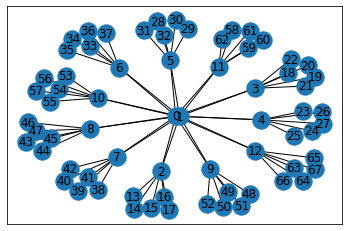

In [100]:
core_edges = [(0, 1), 
              (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), 
              (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]

i = 13
control_edges = copy.deepcopy(core_edges)
for n in range (2, 13):
    for s in range(5):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
nx.draw_networkx(control_beliefs)
#nx.draw_networkx(core_network)


def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q = .75
            else:
                q = .025 # base hazard
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            q = .025 # base hazard
    
    familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
    q *= 1.25**familiarity
    
    adopt =  np.random.binomial(1, np.tanh(q)) == 1
    #print(adopt)
    return adopt


def run(g0, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g0:
        new_edges = []
        for edge in g0.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame



###### This changes:
def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    
    beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res, initial_susceptible, initial_adopted

In [101]:
n_runs=50
runs5 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=4,
        t_match_susceptibility=1,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

runs5.head()

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
1,0.713636,0.572727,0.670820,-0.310530,32.601797,0.213636,0.186364,0.67082,-0.356348,36.576219
1,0.309091,0.172727,1.000000,-0.239046,45.109943,0.190909,0.131818,0.67082,-0.288675,41.372017
1,0.736364,0.377273,1.000000,0.288675,53.512661,0.186364,0.118182,0.76980,-0.222222,36.674164
1,0.259091,0.063636,1.000000,-0.149071,32.460888,0.100000,0.086364,1.00000,-0.222222,33.087975
1,0.513636,0.318182,0.690066,-0.356348,33.988181,0.209091,0.172727,0.67082,-0.288675,25.739163


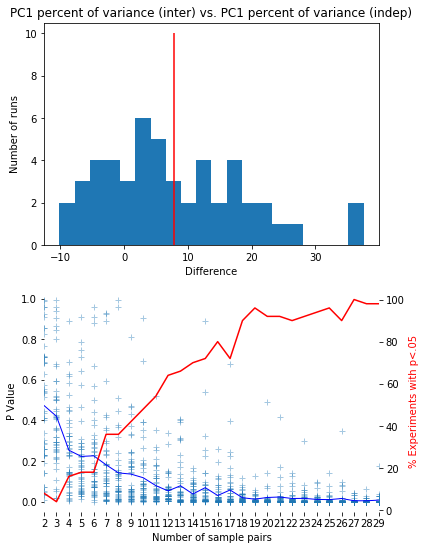

In [102]:
drawfigs(runs5)

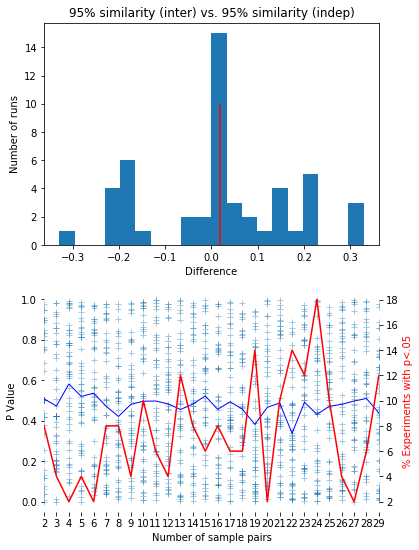

In [103]:
drawfigs(runs5, measures=['95% similarity (inter)', '95% similarity (indep)'])

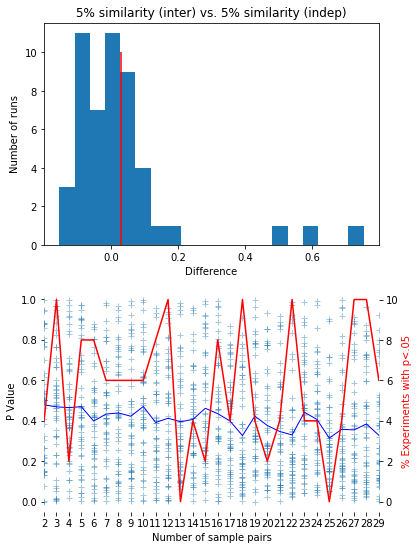

In [104]:
drawfigs(runs5, measures=['5% similarity (inter)', '5% similarity (indep)'])

## 3. smaller experiment (12 players), + remove second core

45

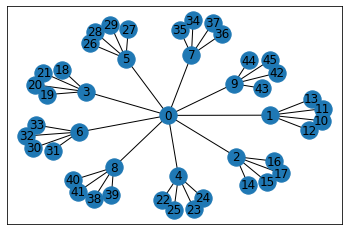

In [11]:
num_rim_nodes = 9 # needs to be odd
core_edges = [(0, i) for i in range(1, num_rim_nodes+1)]

i = num_rim_nodes+1
control_edges = copy.deepcopy(core_edges)
for n in range (1, len(core_edges)+1):
    for s in range(int((num_rim_nodes-1)/2)):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
nx.draw_networkx(control_beliefs)
len(control_edges)
#nx.draw_networkx(core_network)

{0: 0.09090909090909091,
 1: 0.09090909090909091,
 2: 0.09090909090909091,
 3: 0.09090909090909091,
 4: 0.09090909090909091,
 5: 0.09090909090909091,
 6: 0.09090909090909091,
 7: 0.09090909090909091,
 8: 0.09999999999999999,
 9: 0.09999999999999999,
 10: 0.09999999999999999,
 11: 0.09999999999999999}

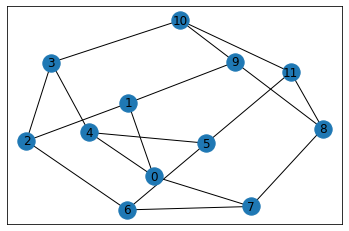

In [12]:
neighbors = [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,0),
             (8,9), (9,10), (10,11), (11,8),
             (7,8), (1,9), (3,10), (5,11),
             (0,4), (2,6)]
g = nx.from_edgelist(neighbors)
nx.draw_networkx(g)
nx.betweenness_centrality(g)

In [22]:
def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m = [measure(g, beliefs)]  # array to collect measurements at each time step
    ts = [0]
    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

        m.append(measure(g, beliefs))  # ignore returned init suscep and adopt
        ts.append(step+1)
        
    return pd.DataFrame(m, index=ts)  # format as pandas DataFrame

def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            if nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2:
                q = .75
            else:
                q = .025 # base hazard
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            # no path exists between the nodes
            q = .025 # base hazard
    
    familiarity = sum([v for k,v in g.nodes[agent]['M'].degree(belief)])
    q *= 1.25**familiarity
    
    adopt =  np.random.binomial(1, np.tanh(q)) == 1
    #print(adopt)
    return adopt

# simple adjustment
def measure(g, beliefs):
    """Take measurements of the state of the system"""
    
    beliefs = [(0,1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res

def run(g0, n_concepts=10, n_beliefs=4, n_steps=6):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g2:
        new_edges = []
        for edge in g2.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame


In [32]:
n_runs=150
runs7 = pd.concat([
    run(g).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T

runs7.head()

,% susceptible (inter),% adopted (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
6,0.462963,0.342593,0.800000,-0.225000,55.362490,0.120370,0.101852,0.755929,-0.250000,49.428539
6,0.342593,0.138889,1.000000,-0.188982,53.644804,0.120370,0.092593,1.000000,-0.188982,54.661537
6,0.453704,0.324074,0.624769,-0.395285,40.740696,0.222222,0.194444,0.661438,-0.316228,35.529502
6,0.333333,0.175926,0.932288,-0.310125,43.507290,0.138889,0.111111,0.881503,-0.251858,38.648671
6,0.472222,0.277778,1.000000,-0.395285,71.295246,0.148148,0.129630,0.816947,-0.250000,43.366493


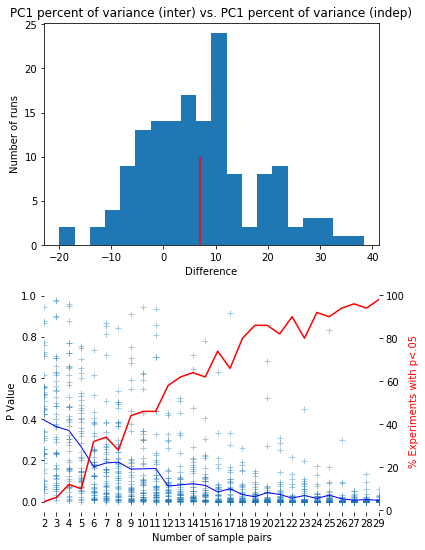

In [71]:
drawfigs(runs7)

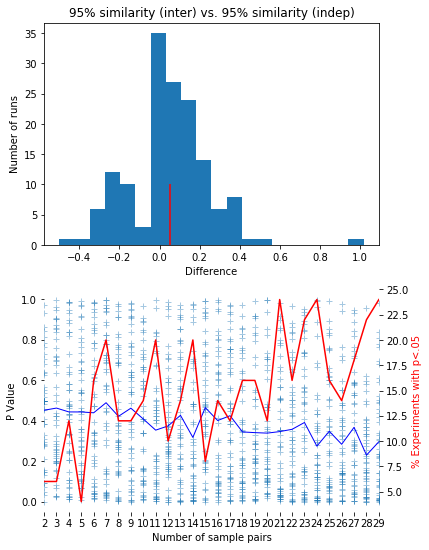

In [72]:
drawfigs(runs7, measures=['95% similarity (inter)', '95% similarity (indep)'])

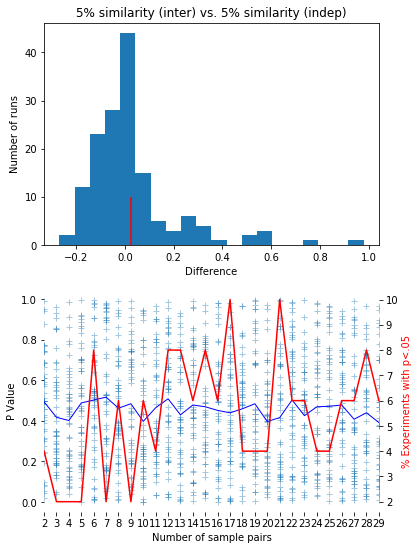

In [73]:
drawfigs(runs7, measures=['5% similarity (inter)', '5% similarity (indep)'])

## 4. Focus on the spokes/spurs

If we told the participants in advance who the suspects were, etc. We could just look at the diffusion of the outer crosslink/spur clues. We'd have more of them, and might get away from some of the messiness around the inner elements. 

The problem with this is that the argument for using the central clues is that we can see the difference in diffusion of the *same* clues from the same starting location. 

## 5. Single core, large experiment

problem with this is that we loose spoke elements, but we don't gain much in terms of number of rim elements. Nothing seems to fit with the nice number of clues per agent. 

91

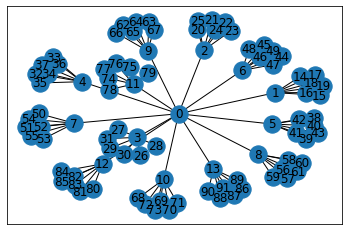

In [112]:
num_rim_nodes = 13 # needs to be odd
core_edges = [(0, i) for i in range(1, num_rim_nodes+1)]

i = num_rim_nodes+1
control_edges = copy.deepcopy(core_edges)
for n in range (1, len(core_edges)+1):
    for s in range(int((num_rim_nodes-1)/2)):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
nx.draw_networkx(control_beliefs)
len(control_edges)


## 6. Different measures for within group, across group similarity
The 5th percentile and 95th percentile cutoffs are arbitrary, and used in the simulation because they are easy to interpret. But fixed thresholds may not be optimal in the experiment, if the whole distribution of similarities is different between the treatment and control cases. (This could happen because of the total number of beliefs adopted.) If one distribution buts up against 1 or 0, it may also have artificially reduced variance. 
We could use a spread measure, like variance in intersubjective similarity, or STD over the difference from the mean to an extrema, to account for bounded data.


## 7. Compare to expected levels for a given level of adoption. 

What if we compared the realized result with what we should expect to see by chance with the same number of beliefs adopted. In the treatment case we should expect to see a larger increase over the random baseline than in the control case. This might be an ok comparison, if what we get by chance takes out network structure effects and any interdependence that we're not able to get out of the control case.

It's not quite as clean a case as a straight comparison between the two. Simulate and see if it gets more power. 

In [ ]:
core_edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]

i = 13
control_edges = copy.deepcopy(core_edges)
for n in range (2, 13):
    for s in range(5):
        control_edges.append((n,i))
        i += 1
    
control_beliefs = nx.from_edgelist(control_edges) 
core_network = nx.from_edgelist(core_edges)
#nx.draw_networkx(control_beliefs)
nx.draw_networkx(core_network)


def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m = [measure(g, beliefs)]  # array to collect measurements at each time step

    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network

    # measure at end
    m.append(measure(g, beliefs))

    return pd.DataFrame(m)  # format as pandas DataFrame

def measure(g, beliefs):
    """Take measurements of the state of the system (for creating figures)"""
    
    beliefs = [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), 
               (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12)]
    
    res = {}  # dictionary to collect measurements

    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs


    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 5B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100
    
    # need to repeat and take averages, or we're just comparing to a different noisy signal
    e95 = []
    e5 = []
    ePC1 = []
    for _ in range(100):
        shuffle_adopt = pd.DataFrame()
        for col in adopt.columns:
            shuffle_adopt[col] = np.random.permutation(adopt[col].values)

        n_agents = len(shuffle_adopt.index)
        corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
        e95.append(np.percentile(corrs, 95))
        e5.append(np.percentile(corrs, 5))

        pca = PCA(n_components=1)
        pca.fit(shuffle_adopt)
        ePC1.append(pca.explained_variance_ratio_[0] * 100)
        
    res['expected PC1 percent of variance'] = np.mean(ePC1)
    res['expected 95% similarity'] = np.mean(e95)
    res['expected 5% similarity'] = np.mean(e5)
        
    return res


def run(g0, n_concepts=25, n_beliefs=25, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model time step at which the interdependent results will be
                                        must be less than or equal to n_steps
    n_steps: (integer) - Number of time steps in the simulation
    """

    # Shared Initial Setup
    # --------------------

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Treatment simulation
    # --------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Control simulation
    # ------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions
    # give spoke and spur beliefs
    for agent in g2:
        new_edges = []
        for edge in g2.nodes[agent]['M'].edges():
            if control_beliefs.has_edge(*edge):
                new_edges.append(edge)
            else:
                end = np.random.choice(edge)
                options = [ne for ne in control_beliefs.edges(end) if not core_network.has_edge(*ne)]
                new_edges.append(options[np.random.randint(len(options))])
                
        g2.nodes[agent]['M'] = nx.from_edgelist(new_edges)
        
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame




n_runs=250
runs8 = pd.concat([
    run(nx.dodecahedral_graph(),
        n_concepts=13,
        n_beliefs=4,
       ).iloc[-1] 
    for _ in range(n_runs)], 
    axis=1).T


runs8.dropna(inplace=True)
n_runs=len(runs8)

runs8.head()

In [ ]:
runs8['net PC1 (inter)'] = runs8['PC1 percent of variance (inter)'] - runs8['expected PC1 percent of variance (inter)']
runs8['net PC1 (indep)'] = runs8['PC1 percent of variance (indep)'] - runs8['expected PC1 percent of variance (indep)']

runs8['net 95% sim (inter)'] = runs8['95% similarity (inter)'] - runs8['expected 95% similarity (inter)']
runs8['net 95% sim (indep)'] = runs8['95% similarity (indep)'] - runs8['expected 95% similarity (indep)']
runs8['net 5% sim (inter)'] = runs8['5% similarity (inter)'] - runs8['expected 5% similarity (inter)']
runs8['net 5% sim (indep)'] = runs8['5% similarity (indep)'] - runs8['expected 5% similarity (indep)']
runs8.head()

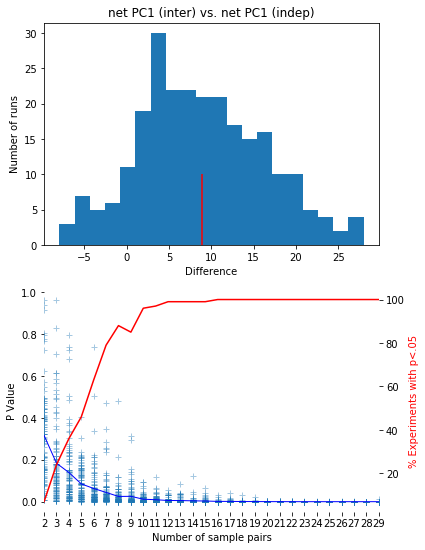

In [148]:
drawfigs(runs8, measures=['net PC1 (inter)', 'net PC1 (indep)'])

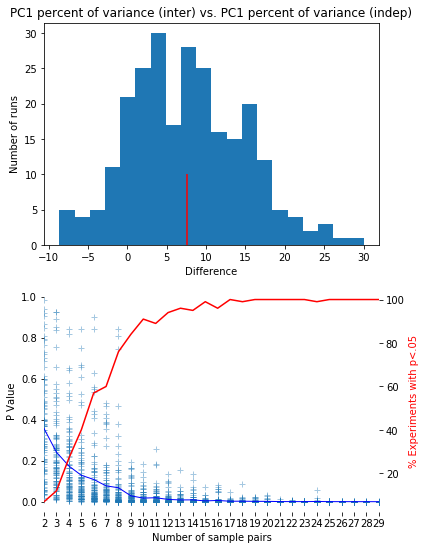

In [149]:
drawfigs(runs8)

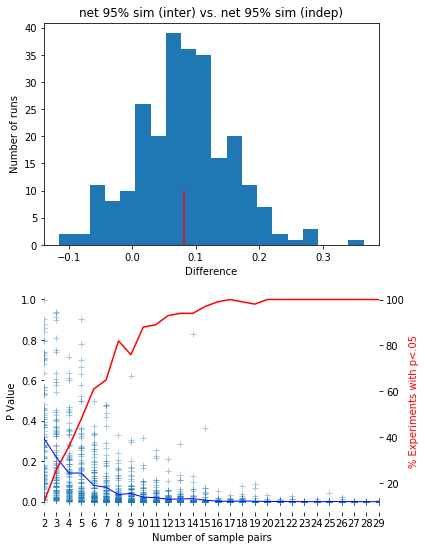

In [150]:
drawfigs(runs8, measures=['net 95% sim (inter)', 'net 95% sim (indep)'])

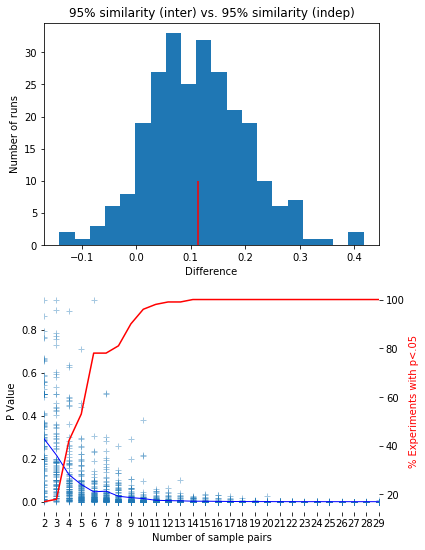

In [151]:
drawfigs(runs8, measures=['95% similarity (inter)', '95% similarity (indep)'])

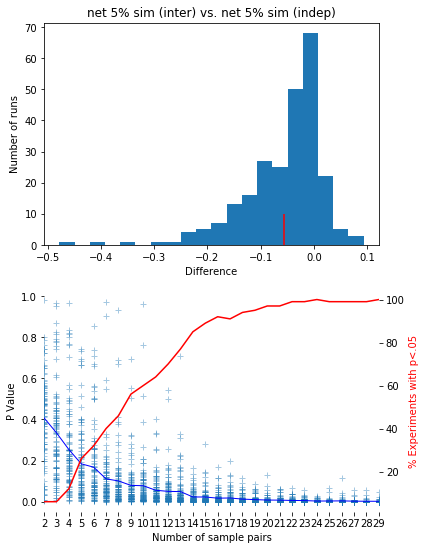

In [152]:
drawfigs(runs8, measures=['net 5% sim (inter)', 'net 5% sim (indep)'])

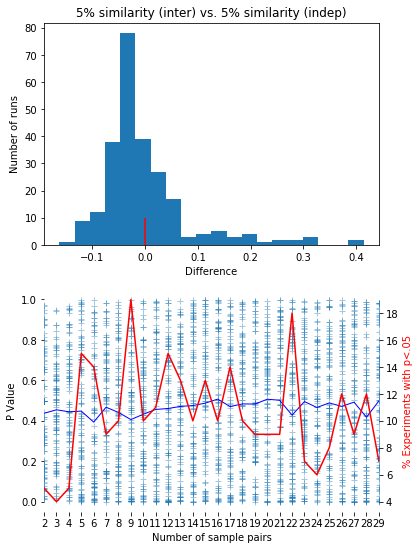

In [153]:
drawfigs(runs8, measures=['5% similarity (inter)', '5% similarity (indep)'])

In [ ]:
! say "calculation complete"